In [ ]:
# in this notebook, I will try to fit a model relating the mean behavior of L4, L2/3, SST and VIP cells

In [ ]:
# load the data

In [1]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import elementwise_grad as egrad
from autograd import grad
from autograd import jacobian
from autograd import hessian
import size_contrast_analysis as sca
import size_contrast_figures as scf
import scipy.stats as sst
import sim_utils
from importlib import reload
reload(sim_utils)
import calnet.utils
import calnet.fitting_spatial_feature_model
import opto_utils
%matplotlib notebook

%load_ext autoreload
%autoreload 2

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
dsbase = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/'
dsnames = [dsbase+x+'_data_struct.hdf5' for x in ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']]

In [3]:
nsize,ncontrast = 6,6

In [4]:
with ut.hdf5read(dsnames[3]) as ds:
    keylist = list(ds.keys())
    print(ds[keylist[0]].keys())

<KeysViewHDF5 ['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0']>


In [5]:
with ut.hdf5read(dsnames[0]) as ds:
    keylist = list(ds.keys())
    print(list(ds[keylist[3]].keys()))

['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0', 'size_contrast_0']


In [6]:
cache_base = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/vip_example_neurons/'
ut.mkdir(cache_base)

In [7]:
def compute_examples_ret():
    to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
    tunings_ret,uparams_ret,displacements,pvals = [[None,None] for ivar in range(4)]
    for irun,run_bool in enumerate([False,True]):
        tunings_ret[irun],uparams_ret[irun],displacements[irun],pvals[irun] = [[] for ivar in range(4)]
        for dsname in dsnames:
            new_vars = sim_utils.compute_tuning(dsname,datafield='decon',running=run_bool,expttype='retinotopy_0')
            tunings_ret[irun] = tunings_ret[irun] + [new_vars[0]]
            uparams_ret[irun] = uparams_ret[irun] + [new_vars[1]]
            displacements[irun] = displacements[irun] + [new_vars[2]]
            pvals[irun] = pvals[irun] + [new_vars[3]]
    tuning_ret_dict = {
            'tunings_ret': tunings_ret,
            'uparams_ret': uparams_ret,
            'displacements': displacements,
            'pvals': pvals,
        }
    return tuning_ret_dict

cache_name = 'tuning_ret_dict.pkl'
tuning_ret_dict = ut.compute_or_load_cached(
    cache_base + cache_name,
    compute_examples_ret,
)


loading from cache...


In [8]:
def compute_examples_F():
    to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
    tunings_sc,uparams_sc,displacements,pvals = [[None,None] for ivar in range(4)]
    for irun,run_bool in enumerate([False,True]):
        tunings_sc[irun],uparams_sc[irun],displacements[irun],pvals[irun] = [[] for ivar in range(4)]
        for dsname in dsnames:
            new_vars = sim_utils.compute_tuning(dsname,datafield='F',running=run_bool,expttype='size_contrast_0')
            tunings_sc[irun] = tunings_sc[irun] + [new_vars[0]]
            uparams_sc[irun] = uparams_sc[irun] + [new_vars[1]]
            displacements[irun] = displacements[irun] + [new_vars[2]]
            pvals[irun] = pvals[irun] + [new_vars[3]]

    tuning_F_dict = {
        'tunings_sc': tunings_sc,
        'uparams_sc': uparams_sc,
        'displacements': displacements,
        'pvals': pvals,
    }
    return tuning_F_dict

cache_name = 'tuning_F_dict.pkl'
tuning_F_dict = ut.compute_or_load_cached(
    cache_base + cache_name,
    compute_examples_F,
)

loading from cache...


In [9]:
def compute_examples_decon():
    to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
    tunings_decon,uparams_decon,displacements,pvals = [[None,None] for ivar in range(4)]
    for irun,run_bool in enumerate([False,True]):
        tunings_decon[irun],uparams_decon[irun],displacements[irun],pvals[irun] = [[] for ivar in range(4)]
        for dsname in dsnames:
            new_vars = sim_utils.compute_tuning(dsname,datafield='decon',running=run_bool,expttype='size_contrast_0')
            tunings_decon[irun] = tunings_decon[irun] + [new_vars[0]]
            uparams_decon[irun] = uparams_decon[irun] + [new_vars[1]]
            displacements[irun] = displacements[irun] + [new_vars[2]]
            pvals[irun] = pvals[irun] + [new_vars[3]]

    tuning_decon_dict = {
        'tunings_decon': tunings_decon,
        'uparams_decon': uparams_decon,
        'displacements': displacements,
        'pvals': pvals,
    }
    return tuning_decon_dict

cache_name = 'tuning_decon_dict.pkl'
tuning_decon_dict = ut.compute_or_load_cached(
    cache_base + cache_name,
    compute_examples_decon,
)


loading from cache...


In [10]:
reload(sim_utils)
def compute_ret_info():
    to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
    ret_info,uparams_sc,displacements,pvals = [[None,None] for ivar in range(4)]
    for irun,run_bool in enumerate([False,True]):
        ret_info[irun] = []
        for dsname in dsnames:
            new_vars = sim_utils.get_ret_info(dsname,expttype='size_contrast_0')
            ret_info[irun] = ret_info[irun] + [new_vars]
    return ret_info

cache_name = 'ret_info.pkl'
ret_info = ut.compute_or_load_cached(
    cache_base + cache_name,
    compute_ret_info,
)

loading from cache...


In [11]:
with ut.hdf5read(dsnames[1]) as ds:
    keylist = list(ds.keys())
    print(ds[keylist[-1]]['size_contrast_0'].keys())

<KeysViewHDF5 ['F', 'decon', 'nafter', 'nbefore', 'neuropil_trialwise', 'raw_trialwise', 'rf_ctr', 'rf_displacement_deg', 'rf_distance_deg', 'rf_mapping_pval', 'running_speed_cm_s', 'stim_offset_deg', 'stimulus_contrast', 'stimulus_direction_deg', 'stimulus_id', 'stimulus_parameters', 'stimulus_size_deg', 't_offset']>


In [12]:
def compute_examples_sst_vip():
    to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
    tunings_sc_sst_vip,uparams_sc_sst_vip = [[None,None] for ivar in range(2)]
    for irun,run_bool in enumerate([False,True]):
        tunings_sc_sst_vip[irun],uparams_sc_sst_vip[irun] = [[] for ivar in range(2)]
        for dsname in dsnames[2:4]:
            new_vars = sim_utils.compute_tuning(dsname,datafield='F',running=run_bool,expttype='size_contrast_0')
            tunings_sc_sst_vip[irun] = tunings_sc_sst_vip[irun] + [new_vars[0]]
            uparams_sc_sst_vip[irun] = uparams_sc_sst_vip[irun] + [new_vars[1]]
    output_dict = {
        'tunings_sc_sst_vip': tunings_sc_sst_vip,
        'uparams_sc_sst_vip': uparams_sc_sst_vip,
    }
    return output_dict

cache_name = 'tuning_sst_vip.pkl'
tuning_sst_vip = ut.compute_or_load_cached(
    cache_base + cache_name,
    compute_examples_sst_vip,
)

loading from cache...


In [13]:
uparams_decon = tuning_decon_dict['uparams_decon']
modal_uparam = uparams_decon[0][0][-1]

In [14]:
tunings_sc = tuning_F_dict['tunings_sc']
for iexpt in range(len(tunings_sc[0][3])):
    if not tunings_sc[0][3][iexpt] is None:
        print(str(iexpt)+': '+str(tunings_sc[0][3][iexpt].shape))

7: (252, 5, 6, 8, 20)
8: (158, 5, 6, 8, 20)
10: (192, 6, 6, 8, 24)
11: (432, 6, 6, 8, 24)
12: (451, 6, 6, 8, 24)


In [15]:
# reload(sim_utils)
# reload(calnet.utils)
# dsnames = [dsbase+x+'_data_struct.hdf5' for x in ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']]
# # dsnames = [dsnames[0],dsnames[2],dsnames[3],dsnames[4]]
# ncelltypes = len(dsnames)
# selection = [None for itype in range(ncelltypes)]
# for itype in range(ncelltypes):
#     with ut.hdf5read(dsnames[itype]) as ds:
#         keylist = list(ds.keys())
#         nexpt = len(keylist)
#         to_keep = np.array([k not in to_exclude for k in keylist])
#         selection[itype] = np.arange(nexpt)[to_keep]
# # selection = utils.default_selection()
# # selection[1] = [0,1,2,3,4,5,7,8,9]
# # selection[3] = None
# reload(calnet.utils)
# # itype = 2
# # rs,expt_ids = calnet.utils.gen_rs_modal_uparam_expt(dsnames=[dsnames[itype]],selection=[selection[itype]],running=False,modal_uparam=modal_uparam,expttype='size_contrast_0',pval_cutoff=1.1,average_ori=False,dcutoff=10.)
# rs,expt_ids,roi_ids = [[None for irun in range(2)] for ivar in range(3)]
# for irun in range(2):
#     rs[irun],expt_ids[irun],roi_ids[irun] = calnet.utils.gen_rs_modal_uparam_expt(dsnames=dsnames,selection=selection,running=irun,\
#                                                                     modal_uparam=modal_uparam,expttype='size_contrast_0',\
#                                                                     pval_cutoff=1.1,average_ori=False,dcutoff=10.,\
#                                                                     run_cutoff=1,running_pct_cutoff=0.2)
# # ut.mkdir('data')
# # np.save('data/celltype_rate_summary.npy',rs)
# # rs = np.load('data/celltype_rate_summary.npy',allow_pickle=True)

In [16]:
reload(sim_utils)
reload(calnet.utils)
reload(ut)
def compute_rs(dcutoff=np.inf, dsname_rg=slice(1, 4)):
    to_exclude = ['session_'+exptname for exptname in ['180714_M9053','180321_M7955', '180519_M8959', '180531_M8961', '180618_M8956','190202_M10075', '190620_M10619']]
    dsnames = [dsbase+x+'_data_struct.hdf5' for x in ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']]
    # dsnames = [dsnames[0],dsnames[2],dsnames[3],dsnames[4]]
    ncelltypes = len(dsnames)
    selection = [None for itype in range(ncelltypes)]
    for itype in range(ncelltypes):
        with ut.hdf5read(dsnames[itype]) as ds:
            keylist = list(ds.keys())
            nexpt = len(keylist)
            to_keep = np.array([k not in to_exclude for k in keylist])
            selection[itype] = np.arange(nexpt)[to_keep]
    # selection = utils.default_selection()
    # selection[1] = [0,1,2,3,4,5,7,8,9]
    # selection[3] = None
    reload(calnet.utils)
    # itype = 2
    # rs,expt_ids = calnet.utils.gen_rs_modal_uparam_expt(dsnames=[dsnames[itype]],selection=[selection[itype]],running=False,modal_uparam=modal_uparam,expttype='size_contrast_0',pval_cutoff=1.1,average_ori=False,dcutoff=10.)
    rs,rs_sem,expt_ids,roi_ids = [[None for irun in range(2)] for ivar in range(4)]
    for irun in range(2):
        rs[irun],rs_sem[irun],expt_ids[irun],roi_ids[irun],_ = calnet.utils.gen_rs_modal_uparam_expt_with_sem(
                dsnames=dsnames[dsname_rg],
                selection=selection[dsname_rg],
                running=irun,
                modal_uparam=modal_uparam,expttype='size_contrast_0',
                pval_cutoff=1.1,average_ori=False,dcutoff=dcutoff,
                run_cutoff=1,running_pct_cutoff=0.2)
    output_dict = {
        'rs': rs,
        'rs_sem': rs_sem,
        'expt_ids': expt_ids,
        'roi_ids': roi_ids,
    }
    return output_dict

cache_name = 'celltype_rate_summary.pkl'
rs_dict = ut.compute_or_load_cached(cache_base + cache_name, compute_rs, dsname_rg=slice(1, 4))
cache_name = 'celltype_rate_summary_dcutoff_10.pkl'
rs_dict_dcutoff_10 = ut.compute_or_load_cached(cache_base + cache_name, compute_rs, dcutoff=10., dsname_rg=slice(1, 4))
cache_name = 'celltype_rate_summary_dcutoff_10_others.pkl'
rs_dict_dcutoff_10_others = ut.compute_or_load_cached(cache_base + cache_name, compute_rs, dcutoff=10., dsname_rg=slice(0, 5, 4))
# ut.mkdir('data')
# np.save('data/celltype_rate_summary.npy',rs)
# rs = np.load('data/celltype_rate_summary.npy',allow_pickle=True)

loading from cache...
loading from cache...
loading from cache...


/Users/dan/Documents/code/adesnal/pyute.py:620: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,rowlen,k+1)


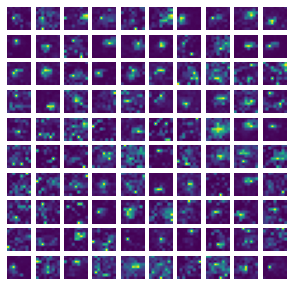

In [18]:
tunings_ret = tuning_ret_dict['tunings_ret']
ut.imshow_in_rows(tunings_ret[0][1][-1][:100,:,:,8:-8].mean(-1))

/Users/dan/Documents/code/adesnal/pyute.py:620: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,rowlen,k+1)


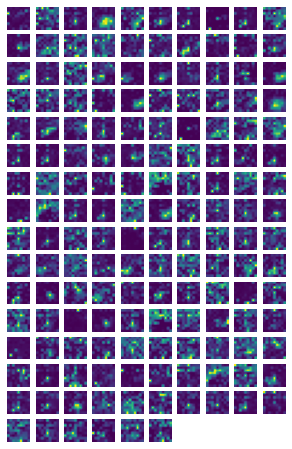

In [19]:
ut.imshow_in_rows(tunings_ret[0][2][8][:,:,:,8:-8].mean(-1))

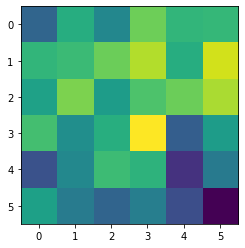

In [20]:
plt.figure()
plt.imshow(tunings_sc[0][3][11][:,:,:,:,8:-8].mean(-1).mean(-1)[58])

In [21]:
this_ncontrast = 3
cfrac = np.linspace(1,0,this_ncontrast+1)[:-1]
c_l4 = cfrac[:,np.newaxis]*np.array(((0,1,0)))
c_sst = cfrac[:,np.newaxis]*np.array(((1,0.5,0)))
c_vip = cfrac[:,np.newaxis]*np.array(((1,0,1)))
c_pv = cfrac[:,np.newaxis]*np.array(((0,0,1)))
c_l23 = cfrac[:,np.newaxis]*np.array(((0.5,0.5,0.5)))

In [22]:
modal_uparam[0].shape

(6,)

In [23]:
def average_axes(arr, axes):
    if not isinstance(axes, (list, tuple)):
        return np.nanmean(arr, axis=axes)
    mn = arr.copy()
    for ax in axes:
        mn = np.nanmean(arr, axis=ax, keepdims=True)
    slicer = [slice(None) for _ in range(arr.ndim)]
    for ax in axes:
        slicer[ax] = 0
    return mn[tuple(slicer)]

In [24]:
def get_rs_iterator(rs):
    for irun in range(len(rs)):
        for itype in range(len(rs[irun])):
            for ialign in range(len(rs[irun][itype])):
                yield rs[irun][itype][ialign], (irun, itype, ialign)

def clone_rs_shape(rs, iter):
    rs_clone = [[] for irun in range(len(rs))]
    for irun in range(len(rs)):
        rs_clone[irun] = [[] for itype in range(len(rs[irun]))]
        for itype in range(len(rs[irun])):
            rs_clone[irun][itype] = [[] for ialign in range(len(rs[irun][itype]))]
            for ialign in range(len(rs[irun][itype])):
                rs_clone[irun][itype][ialign] = next(iter)
    return rs_clone

def preprocess_and_subtract_mean(r):
    r_norm = preprocess(r)
    r_norm = get_non_nan_neurons(r_norm)
    r_norm = get_non_nan_stims(r_norm)
    print(r_norm.shape)
    if r_norm.shape[1] == 0:
        print('all stims have some nan')
        return None, None, None
    r_mean = np.nanmean(r_norm, axis=0, keepdims=True)
    # print(np.mean(np.abs(r_norm - r_mean)))
    # print(np.mean(np.std(r_norm - r_mean, axis=0)))
    return r_norm - r_mean

def get_mean_and_first_pc(r, size_rg=None):
    if not size_rg is None:
        r = r[:, size_rg]
    rsub = preprocess_and_subtract_mean(r)
    r_pc = compute_pc1_(rsub)
    r_norm = preprocess(r)
    r_norm = get_non_nan_neurons(r_norm)
    r_norm = get_non_nan_stims(r_norm)
    print(r_norm.shape)
    if r_norm.shape[1] == 0:
        print('all stims have some nan')
        return None, None, None
    r_mean = np.nanmean(r_norm, axis=0, keepdims=True)
    # print(np.mean(np.abs(r_norm - r_mean)))
    # print(np.mean(np.std(r_norm - r_mean, axis=0)))
    r_pc = compute_pc1_(r_norm - r_mean) # does not work b/c of nans in r_norm
    r_mean = r_mean.reshape(r.shape[1:3])
    r_pc = r_pc.reshape(r.shape[1:3])
    return r_mean, (r_mean + r_pc), (r_mean - r_pc)

def preprocess(r):
    r_ori = average_ori(r)
    r_flat = flatten_stims(r_ori)
    r_norm = norm_to_mean(r_flat)
    return r_norm

def compute_pc1_(r_mean_sub):
    u, s, v = np.linalg.svd(r_mean_sub, full_matrices=False)
    return s[0] * v[0, :] / np.sqrt(u.shape[0])

def compute_eigenspectrum(r_mean_sub):
    u, s, v = np.linalg.svd(r_mean_sub, full_matrices=False)
    return s

def get_non_nan_stims(r_mean_sub):
    non_nan_mask = ~np.isnan(r_mean_sub)
    non_nan_stims = np.all(non_nan_mask, axis=0)
    # assert(np.sum(non_nan_stims))
    return r_mean_sub[:, non_nan_stims]
    
def get_non_nan_neurons(r_mean_sub):
    non_nan_mask = ~np.isnan(r_mean_sub)
    non_nan_neurons = np.all(non_nan_mask, axis=1)
    # assert(np.sum(non_nan_neurons))
    return r_mean_sub[non_nan_neurons, :]

def average_ori(r):
    return np.nanmean(r, axis=3)

def flatten_stims(r):
    return r.reshape(r.shape[0], -1)

def norm_to_mean(r):
    return r / np.nanmean(r, axis=1, keepdims=True)

rs = [
    (rs_dict_dcutoff_10_others['rs'][irun][0:1] 
    + rs_dict_dcutoff_10['rs'][irun] 
    + rs_dict_dcutoff_10_others['rs'][irun][1:]) for irun in range(len(rs_dict_dcutoff_10['rs']))]

r_pcs = []
spectra = []
i = 0
size_rg = slice(None, 5)
for r, itup in get_rs_iterator(rs):
    print(i)
    i += 1
    r, r_plus_pc, r_minus_pc = get_mean_and_first_pc(r, size_rg=size_rg)
    spectra.append(compute_eigenspectrum(r))
    r_pcs.append([r, r_plus_pc, r_minus_pc])
    if r is None:
        print(itup)
nsize, ncontrast = 5, 6
r_pcs = clone_rs_shape(rs, iter(r_pcs))

0
(7575, 30)
(7575, 30)
1
(2378, 30)
(2378, 30)
2
(12051, 30)
(12051, 30)
3
(4447, 30)
(4447, 30)
4
(867, 30)
(867, 30)
5
(345, 30)
(345, 30)
6
(837, 30)
(837, 30)
7
(850, 30)
(850, 30)
8
(283, 30)
(283, 30)
9
(149, 30)
(149, 30)
10
(9414, 30)
(9414, 30)
11
(3513, 30)
(3513, 30)
12
(8292, 30)
(8292, 30)
13
(3688, 30)
(3688, 30)
14
(716, 30)
(716, 30)
15
(290, 30)
(290, 30)
16
(737, 30)
(737, 30)
17
(635, 30)
(635, 30)
18
(148, 30)
(148, 30)
19
(12, 30)
(12, 30)


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


In [25]:
running_labels = ['non-running', 'running']
celltype_labels = ['L4 PC', 'L2/3 PC', 'SST', 'VIP', 'PV']
align_labels = ['center', 'surround']
for irun in range(len(rs)):
    for itype in range(len(rs[irun])):
        for ialign in range(len(rs[irun][itype])):
            ncells = (rs[irun][itype][ialign].shape[0])
            print(' '.join([running_labels[irun], celltype_labels[itype], align_labels[ialign]])+': '+str(ncells))

non-running L4 PC center: 7575
non-running L4 PC surround: 2378
non-running L2/3 PC center: 12051
non-running L2/3 PC surround: 4447
non-running SST center: 867
non-running SST surround: 345
non-running VIP center: 837
non-running VIP surround: 850
non-running PV center: 283
non-running PV surround: 149
running L4 PC center: 9414
running L4 PC surround: 3513
running L2/3 PC center: 8292
running L2/3 PC surround: 3688
running SST center: 716
running SST surround: 290
running VIP center: 1085
running VIP surround: 729
running PV center: 148
running PV surround: 12


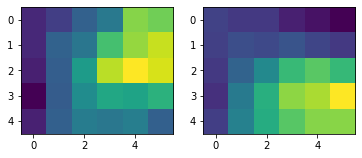

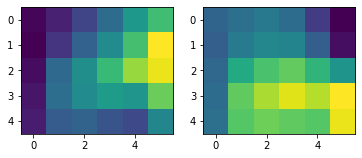

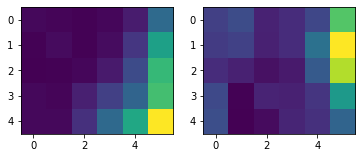

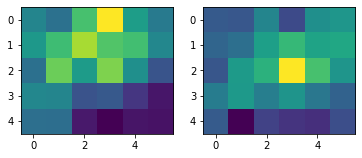

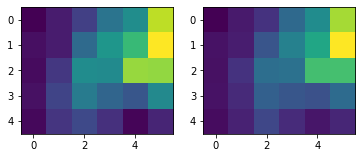

In [26]:
irun = 0
ialign = 0
for itype in range(5):
    plt.figure()
    for ipc in range(2):
        plt.subplot(1, 2, ipc+1)
        # plt.plot(r_pcs[irun][itype][ialign][ipc].reshape((nsize, ncontrast)).T)
        plt.imshow(r_pcs[irun][itype][ialign][ipc].reshape((nsize, ncontrast)))

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/Users/dan/Documents/code/adesnal/size_contrast_figures.py:802: RuntimeWarning: All-NaN slice encountered
  return this_data[:,:,1]/np.nanmax(this_data,2)


(837, 6)


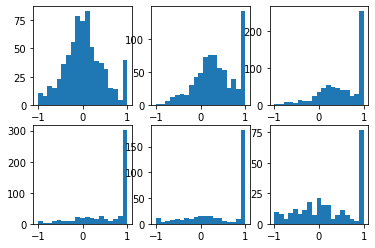

In [33]:
irun = 0
itype = 3
ialign = 0
rs_vip = rs[irun][itype][ialign]
rs_vip = np.nanmean(rs_vip, -1)
# zero contrast is the 0 element of axis 2
rs_vip_zero = rs_vip[:, :, 0]
# take the mean along axis 1
rs_vip_zero_mean = np.nanmean(rs_vip_zero, 1)
# add singleton axes to make it broadcastable
rs_vip_zero_mean = rs_vip_zero_mean[:, np.newaxis, np.newaxis]
rs_vip = rs_vip - rs_vip_zero_mean
assert(len(rs_vip.shape) == 3)
csi = scf.csi_fn(rs_vip, avg_last=False, subtract_min=False)
print(csi.shape)
plt.figure()
for isize in range(6):
    plt.subplot(2, 3, isize+1)
    csi_summary = csi[:, isize]
    # csi_summary = np.nanmean(csi, 1)
    plt.hist(csi_summary, bins=np.linspace(-1, 1, 20))
# plt.colorbar()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


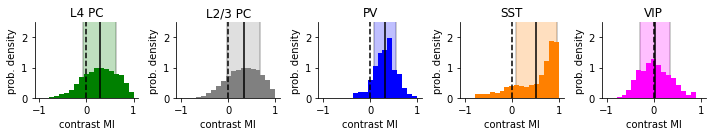

In [91]:
irun = 0
ialign = 0
def compute_delta(itype):
    rs_vip = rs[irun][itype][ialign]
    rs_vip = np.nanmean(rs_vip, -1)
    # zero contrast is the 0 element of axis 2
    rs_vip_zero = rs_vip[:, :, 0]
    # take the mean along axis 1
    rs_vip_zero_mean = np.nanmean(rs_vip_zero, 1)
    # isize = 3
    # icontrast = 1
    # delta_rs = rs_vip[:, isize, icontrast] - rs_vip_zero_mean

    rs_vip_nonzero_mean = np.nanmean(np.nanmean(rs_vip[:, :, 1:], 1), 1)
    rs_vip_all_mean = np.nanmean(np.nanmean(rs_vip, 1), 1)
    delta_rs = (rs_vip_nonzero_mean - rs_vip_zero_mean) / (rs_vip_nonzero_mean + rs_vip_zero_mean)
    return delta_rs
def bar_plot_pdf(vals, bins, c='b'):
    hist, _ = np.histogram(vals, bins=bins)
    pdf = hist / np.sum(hist) / (bins[1] - bins[0])
    plt.bar(0.5*bins[:-1]+0.5*bins[1:], pdf, width=np.diff(bins), color=c)
def plot_mean_and_std(delta_rs, ylim, zorder_std=0, zorder_mean=None):
    # plot a solid vertical line at the mean
    delta_mean = np.nanmean(delta_rs)
    plt.axvline(delta_mean, linestyle='-', color='k', zorder=zorder_mean)
    # fill between the elements of ylim over mean - std. to mean + std.
    delta_std = np.nanstd(delta_rs)
    x_fill_between = (delta_mean - delta_std, delta_mean + delta_std)
    ys_fill_between = [[ylim[i]] * 2 for i in range(2)]
    plt.fill_between(x_fill_between, *ys_fill_between, facecolor=colors[itype], alpha=0.25)
    # plot a solid gray vertical line at mean +/- std.
    plt.axvline(delta_mean - delta_std, linestyle='-', color=[std_gray] * 3, zorder=zorder_std)
    plt.axvline(delta_mean + delta_std, linestyle='-', color=[std_gray] * 3, zorder=zorder_std)
plt.figure(figsize=(10, 2))
colors = scf.CELLTYPE_COLORS
ylim = (0, 2.5)
std_gray = 0.75
for itype_reordered, itype in enumerate([0, 1, 4, 2, 3]):
    delta_rs = compute_delta(itype)
    plt.subplot(1, 5, itype_reordered+1)
    plot_mean_and_std(delta_rs, ylim)
    bar_plot_pdf(delta_rs, np.linspace(-1, 1, 20), c=colors[itype])
    # plt.hist(delta_rs, bins=np.linspace(-0.1, 0.1, 20))
    # plot a dashed vertical line at 0
    plt.axvline(0, linestyle='--', color='k')
    plt.ylim(ylim)
    ut.erase_top_right()
    plt.title(scf.FULL_CELLTYPE_LABELS[itype])
    plt.xlabel("contrast MI")
    plt.ylabel("prob. density")
    plt.tight_layout()
    plt.savefig("figures/nonzero_minus_zero_contrast_response_bar_plots.jpg", dpi=300)
    plt.savefig("figures/nonzero_minus_zero_contrast_response_bar_plots.eps")

In [55]:
colors[0]

array([[0.        , 1.        , 0.        ],
       [0.        , 0.66666667, 0.        ],
       [0.        , 0.33333333, 0.        ]])

(1, 6, 6)
1.4143712610559311
1.4143712610559311
(1, 6, 6)
1.5153146980311845
1.5153146980311845


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.5691901623317106
1.5691901623317106
(1, 6, 6)
1.5213596016749171
1.5213596016749171


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
3.2947243596975704
3.2947243596975704
(1, 6, 6)
1.7428051152087107
1.7428051152087107


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.8300720603571379
1.8300720603571379
(1, 6, 6)
2.02517900512332
2.02517900512332


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.8255870668046181
1.8255870668046181
(1, 6, 6)
2.548197528284886
2.548197528284886


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.3266258199218164
1.3266258199218164
(1, 6, 6)
1.4906915838306132
1.4906915838306132


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.5142924758699678
1.5142924758699678
(1, 6, 6)
2.312399180795384
2.312399180795384


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
4.6199482529407
4.6199482529407
(1, 6, 6)
2.189548856672489
2.189548856672489


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.5496844150931295
1.5496844150931295
(1, 6, 6)
2.495779746102888
2.495779746102888


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.5864323533348053
1.5864323533348053
(1, 6, 6)
1.6265453454871703
1.6265453454871703


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.6208477955272869
1.6208477955272869
(1, 6, 6)
1.9443413588193146
1.9443413588193146


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.966231093073358
1.966231093073358
(1, 6, 6)
2.3145058254533932
2.3145058254533932


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
3.504307072072129
3.504307072072129
(1, 6, 6)
5.627604563659915
5.627604563659915


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.6227659140584356
1.6227659140584356
(1, 6, 6)
1.8910508600287952
1.8910508600287952


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
2.1834160153024507
2.1834160153024507
(1, 6, 6)
2.9584729348592154
2.9584729348592154


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.797164813786982
1.797164813786982
(1, 6, 6)
1.9161202892286844
1.9161202892286844


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.6865053902440321
1.6865053902440321
(1, 6, 6)
2.7949594762783234
2.7949594762783234


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
3.7816547867190176
3.7816547867190176
(1, 6, 6)
6.519283562403482
6.519283562403482


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
1.7413293649205042
1.7413293649205042
(1, 6, 6)
1.927930522171542
1.927930522171542


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 6, 6)
2.390541516215859
2.390541516215859
(1, 6, 6)
2.4008041242659344
2.4008041242659344


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


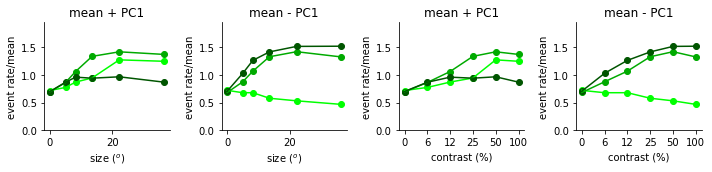

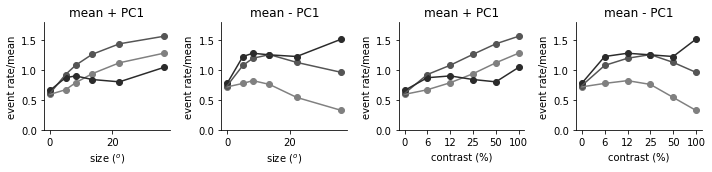

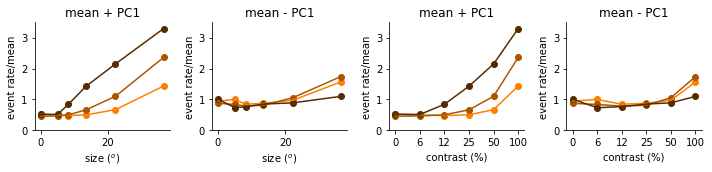

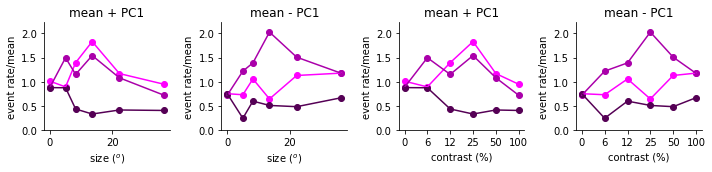

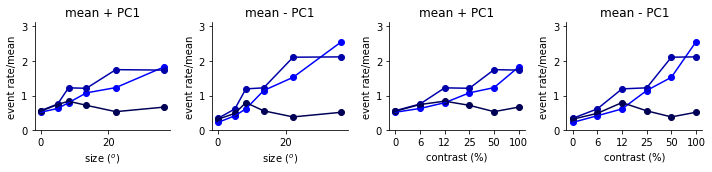

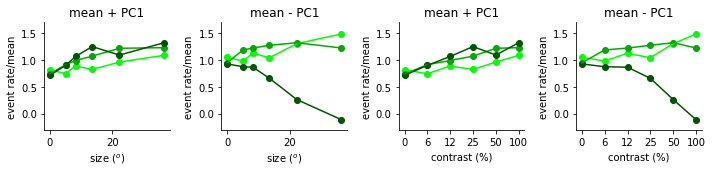

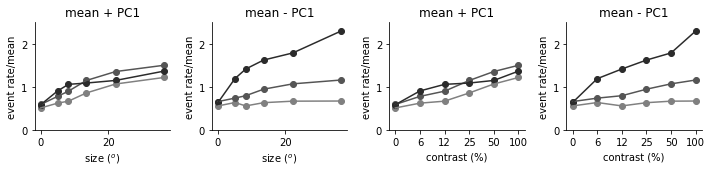

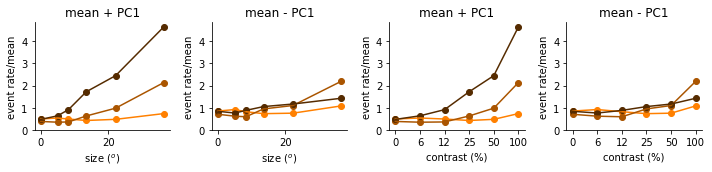

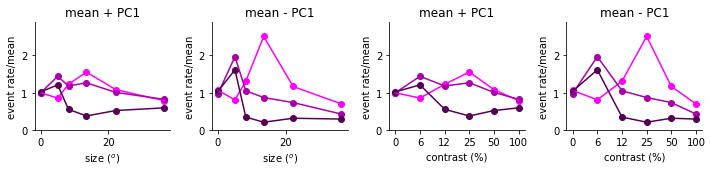

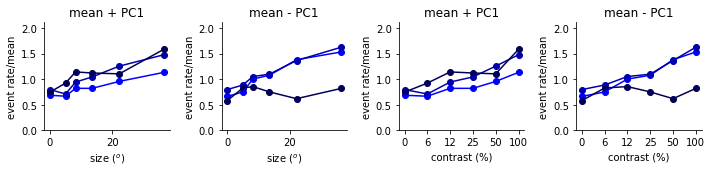

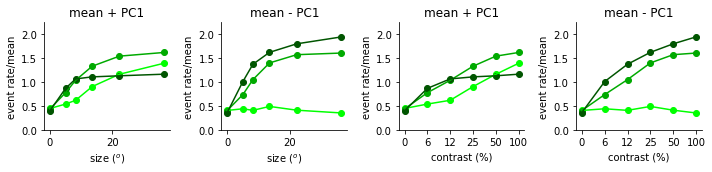

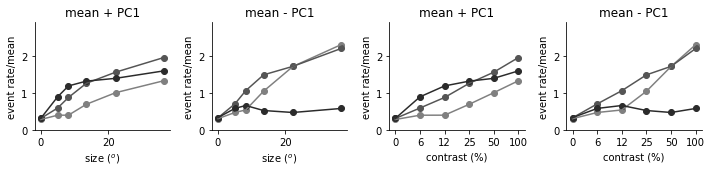

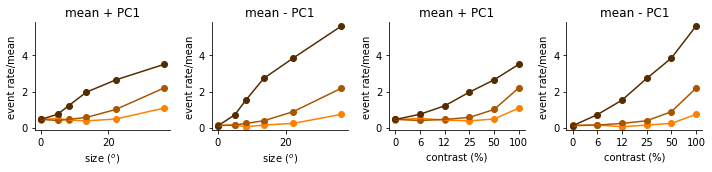

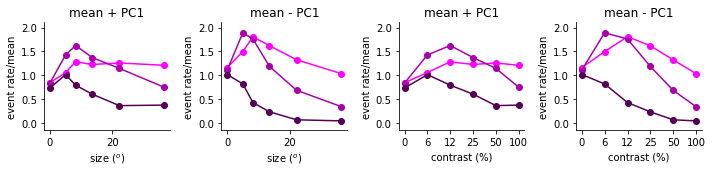

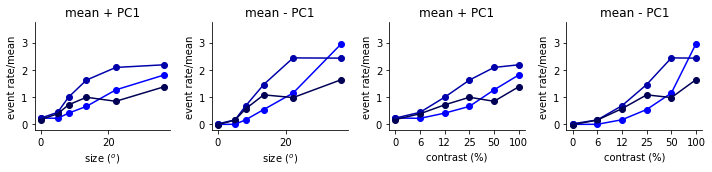

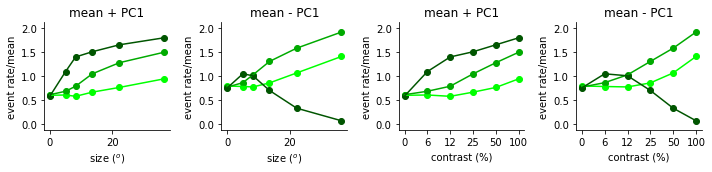

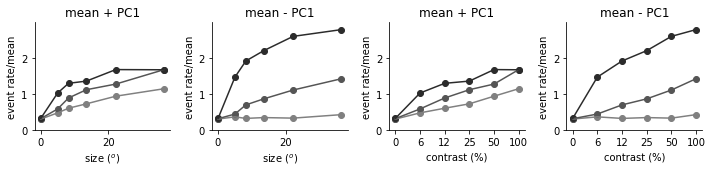

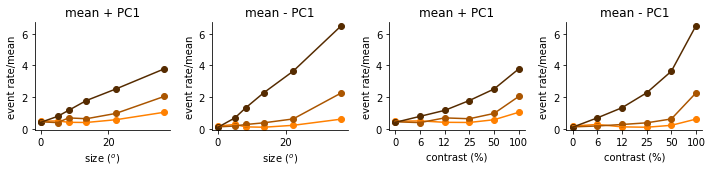

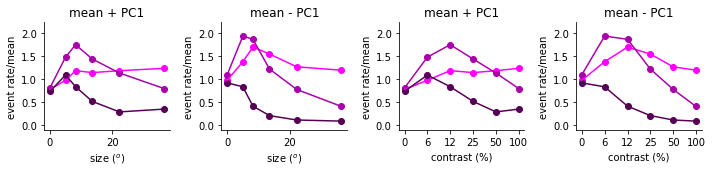

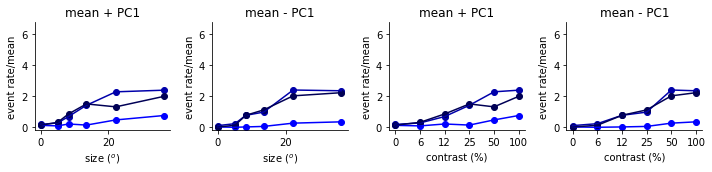

In [44]:
# reload(scf)
celltype_titles = ["L4 PC", "L2/3 PC", "L2/3 SST", "L2/3 VIP", "L2/3 PV"]
usize = np.geomspace(5, 60, 6)[:5]
usize0 = np.concatenate(((0,),usize))
ucontrast = np.array((0,6,12,25,50,100))
icontrast_to_show = [1, 3, 5]
isize_to_show = [0, 2, 4]
nlines_to_show = len(icontrast_to_show)
assert(len(isize_to_show) == nlines_to_show)
colors_for_2d = scf.gen_2d_colors_(nlines_to_show, colors=scf.CELLTYPE_COLORS)
colors_for_2d[0] = 2 * colors_for_2d[0]
ialign = 0
ylabel = 'event rate/mean'# event rate'
y_epsilon = 0.2
for irun in range(2):
    for ialign in range(2):
        def plot_size_tuning(ydata, colors=None):
            ydata = sim_utils.gen_size_tuning(ydata).T
            ut.plot_bootstrapped_errorbars_hillel(usize0, (ydata.T)[None, icontrast_to_show], colors=colors)
            plt.ylabel(ylabel)
            plt.xlabel(r'size ($^o$)')
        def plot_contrast_tuning(ydata, colors=None):
            x = np.arange(len(ucontrast))
            ut.plot_bootstrapped_errorbars_hillel(x, (ydata)[None, isize_to_show], colors=colors)
            plt.xticks(x, ucontrast)
            plt.ylabel(ylabel)
            plt.xlabel('contrast (%)')
        pc_titles = ['mean + PC1', 'mean - PC1']
        for itype in range(5):
            plt.figure(figsize=(10, 2.5))
            ymin = np.inf
            ymax = -np.inf
            for ipc in range(2):
                plt.subplot(1, 4, ipc+1)
                ydata = r_pcs[irun][itype][ialign][ipc].reshape((nsize, ncontrast))
                # plt.plot(r_pcs[irun][itype][ialign][ipc].reshape((nsize, ncontrast)).T)
                plot_size_tuning(ydata, colors=colors_for_2d[itype])
                plt.title(pc_titles[ipc])
                plt.subplot(1, 4, ipc+3)
                plot_contrast_tuning(ydata, colors=colors_for_2d[itype])
                ymin = np.minimum(ydata.min(), ymin)
                ymax = np.maximum(ydata.max(), ymax)
                plt.title(pc_titles[ipc])
            # plt.suptitle(celltype_titles[itype])
            for iplot in range(4):
                plt.subplot(1, 4, iplot+1)
                plt.ylim((ymin - y_epsilon, ymax + y_epsilon))
                if ymin - y_epsilon > 0:
                    plt.ylim(bottom=0)
                ut.erase_top_right()
                plt.tight_layout()
            # set ylim lower bound to zero
            plt.savefig('figures/variability_running_%d_celltype_%d_surround_%d.eps'%(irun,itype,ialign))


In [59]:
reload(ut)
save_fig = False
rs = rs_dict['rs']
rs_sem = rs_dict['rs_sem']
expt_ids = rs_dict['expt_ids']
roi_ids = rs_dict['roi_ids']
# c_vip = np.array(((0.3,0,0.3),(0.6,0,0.6),(1,0,1)))
irun = 0
ialign = 0
itype = 2
iexpt = 11
for iroi in [57,58]:
    this_rs = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi],-1)
    mn = np.nanmean(this_rs)
    this_rs = this_rs/mn
    this_rs_sem = np.sqrt(np.nansum(rs_sem[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi]**2,-1))/8/mn
    this_rs = sim_utils.gen_size_tuning(this_rs[np.newaxis])[0]
    this_rs_sem = sim_utils.gen_size_tuning_sem(this_rs_sem[np.newaxis])[0]
    usize0 = np.concatenate(((0,),modal_uparam[0]))
    deltas = [-1,0,1]
    plt.figure(figsize=(2.5,2.5))
    # for iicontrast,icontrast in enumerate([1,3,5]):
    #     plt.errorbar(modal_uparam[0]+deltas[iicontrast],this_rs[:,icontrast],this_rs_sem[:,icontrast])
    ut.plot_sem_errorbars_hillel(usize0,this_rs[:,[1,3,5]].T,this_rs_sem[:,[1,3,5]].T,delta=0.3,colors=c_vip,linewidth=1.5)
    plt.ylabel('event rate/mean event rate')
    plt.xlabel('size ($^o$)')
    plt.tight_layout()
    ut.erase_top_right()
    if save_fig:
        plt.savefig('figures/example_vip_neuron_expt_%d_roi_%d.eps'%(iexpt,iroi))
    

(1, 7, 6)
(1, 7, 6)


<IPython.core.display.Javascript object>

(1, 7, 6)
(1, 7, 6)


<IPython.core.display.Javascript object>

(1, 7, 6)
(1, 7, 6)


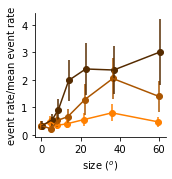

In [52]:
reload(ut)
save_fig = False
rs = rs_dict['rs']
rs_sem = rs_dict['rs_sem']
expt_ids = rs_dict['expt_ids']
roi_ids = rs_dict['roi_ids']
# c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
irun = 0
ialign = 0
itype = 1
iexpt = 8
for iroi in [3]:
    this_rs = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi],-1)
    mn = np.nanmean(this_rs)
    this_rs = this_rs/mn
    this_rs_sem = np.sqrt(np.nansum(rs_sem[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi]**2,-1))/8/mn
    this_rs = sim_utils.gen_size_tuning(this_rs[np.newaxis])[0]
    this_rs_sem = sim_utils.gen_size_tuning_sem(this_rs_sem[np.newaxis])[0]
    usize0 = np.concatenate(((0,),modal_uparam[0]))
    deltas = [-1,0,1]
    plt.figure(figsize=(2.5,2.5))
    # for iicontrast,icontrast in enumerate([1,3,5]):
    #     plt.errorbar(modal_uparam[0]+deltas[iicontrast],this_rs[:,icontrast],this_rs_sem[:,icontrast])

    ut.plot_sem_errorbars_hillel(usize0,this_rs[:,[1,3,5]].T,this_rs_sem[:,[1,3,5]].T,delta=0.3,colors=c_sst,linewidth=1.5)
    plt.ylabel('event rate/mean event rate')
    plt.xlabel('size ($^o$)')
    plt.tight_layout()
    ut.erase_top_right()
    if save_fig:
        plt.savefig('figures/example_sst_neuron_expt_%d_roi_%d.eps'%(iexpt,iroi))
    

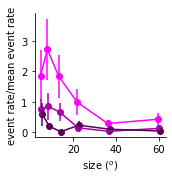

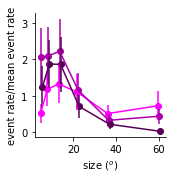

In [61]:
reload(ut)

# c_vip = np.array(((0.3,0,0.3),(0.6,0,0.6),(1,0,1)))
irun = 0
ialign = 0
itype = 2
iexpt = 11
default_linewidth = 1.5
for iroi in [57,58]:
    this_rs = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi],-1)
    mn = np.nanmean(this_rs)
    this_rs = this_rs/mn
    this_rs_sem = np.sqrt(np.nansum(rs_sem[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi]**2,-1))/8/mn
    deltas = [-1,0,1]
    plt.figure(figsize=(2.5,2.5))
    # for iicontrast,icontrast in enumerate([1,3,5]):
    #     plt.errorbar(modal_uparam[0]+deltas[iicontrast],this_rs[:,icontrast],this_rs_sem[:,icontrast])

    ut.plot_sem_errorbars_hillel(modal_uparam[0],this_rs[:,[1,3,5]].T,this_rs_sem[:,[1,3,5]].T,delta=0.3,colors=c_vip, linewidth=default_linewidth)
    plt.ylabel('event rate/mean event rate')
    plt.xlabel('size ($^o$)')
    plt.tight_layout()
    ut.erase_top_right()
    if save_fig:
        plt.savefig('figures/example_vip_neuron_expt_%d_roi_%d.eps'%(iexpt,iroi))
    

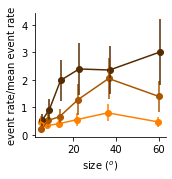

In [63]:
reload(ut)
# c_sst = np.array(((0.3,0.2,0),(0.6,0.4,0),(1,0.65,0)))
irun = 0
ialign = 0
itype = 1
iexpt = 8
save_fig = False
for iroi in [3]:
    this_rs = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi],-1)
    mn = np.nanmean(this_rs)
    this_rs = this_rs/mn
    this_rs_sem = np.sqrt(np.nansum(rs_sem[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi]**2,-1))/8/mn
    deltas = [-1,0,1]
    plt.figure(figsize=(2.5,2.5))
    # for iicontrast,icontrast in enumerate([1,3,5]):
    #     plt.errorbar(modal_uparam[0]+deltas[iicontrast],this_rs[:,icontrast],this_rs_sem[:,icontrast])

    ut.plot_sem_errorbars_hillel(modal_uparam[0],this_rs[:,[1,3,5]].T,this_rs_sem[:,[1,3,5]].T,delta=0.3,colors=c_sst, linewidth=default_linewidth)
    plt.ylabel('event rate/mean event rate')
    plt.xlabel('size ($^o$)')
    plt.tight_layout()
    ut.erase_top_right()
    if save_fig:
        plt.savefig('figures/example_sst_neuron_expt_%d_roi_%d.eps'%(iexpt,iroi))
    

In [64]:
print(modal_uparam[0].shape,this_rs[:,[1,3,5]].T.shape)

(6,) (3, 6)


<IPython.core.display.Javascript object>


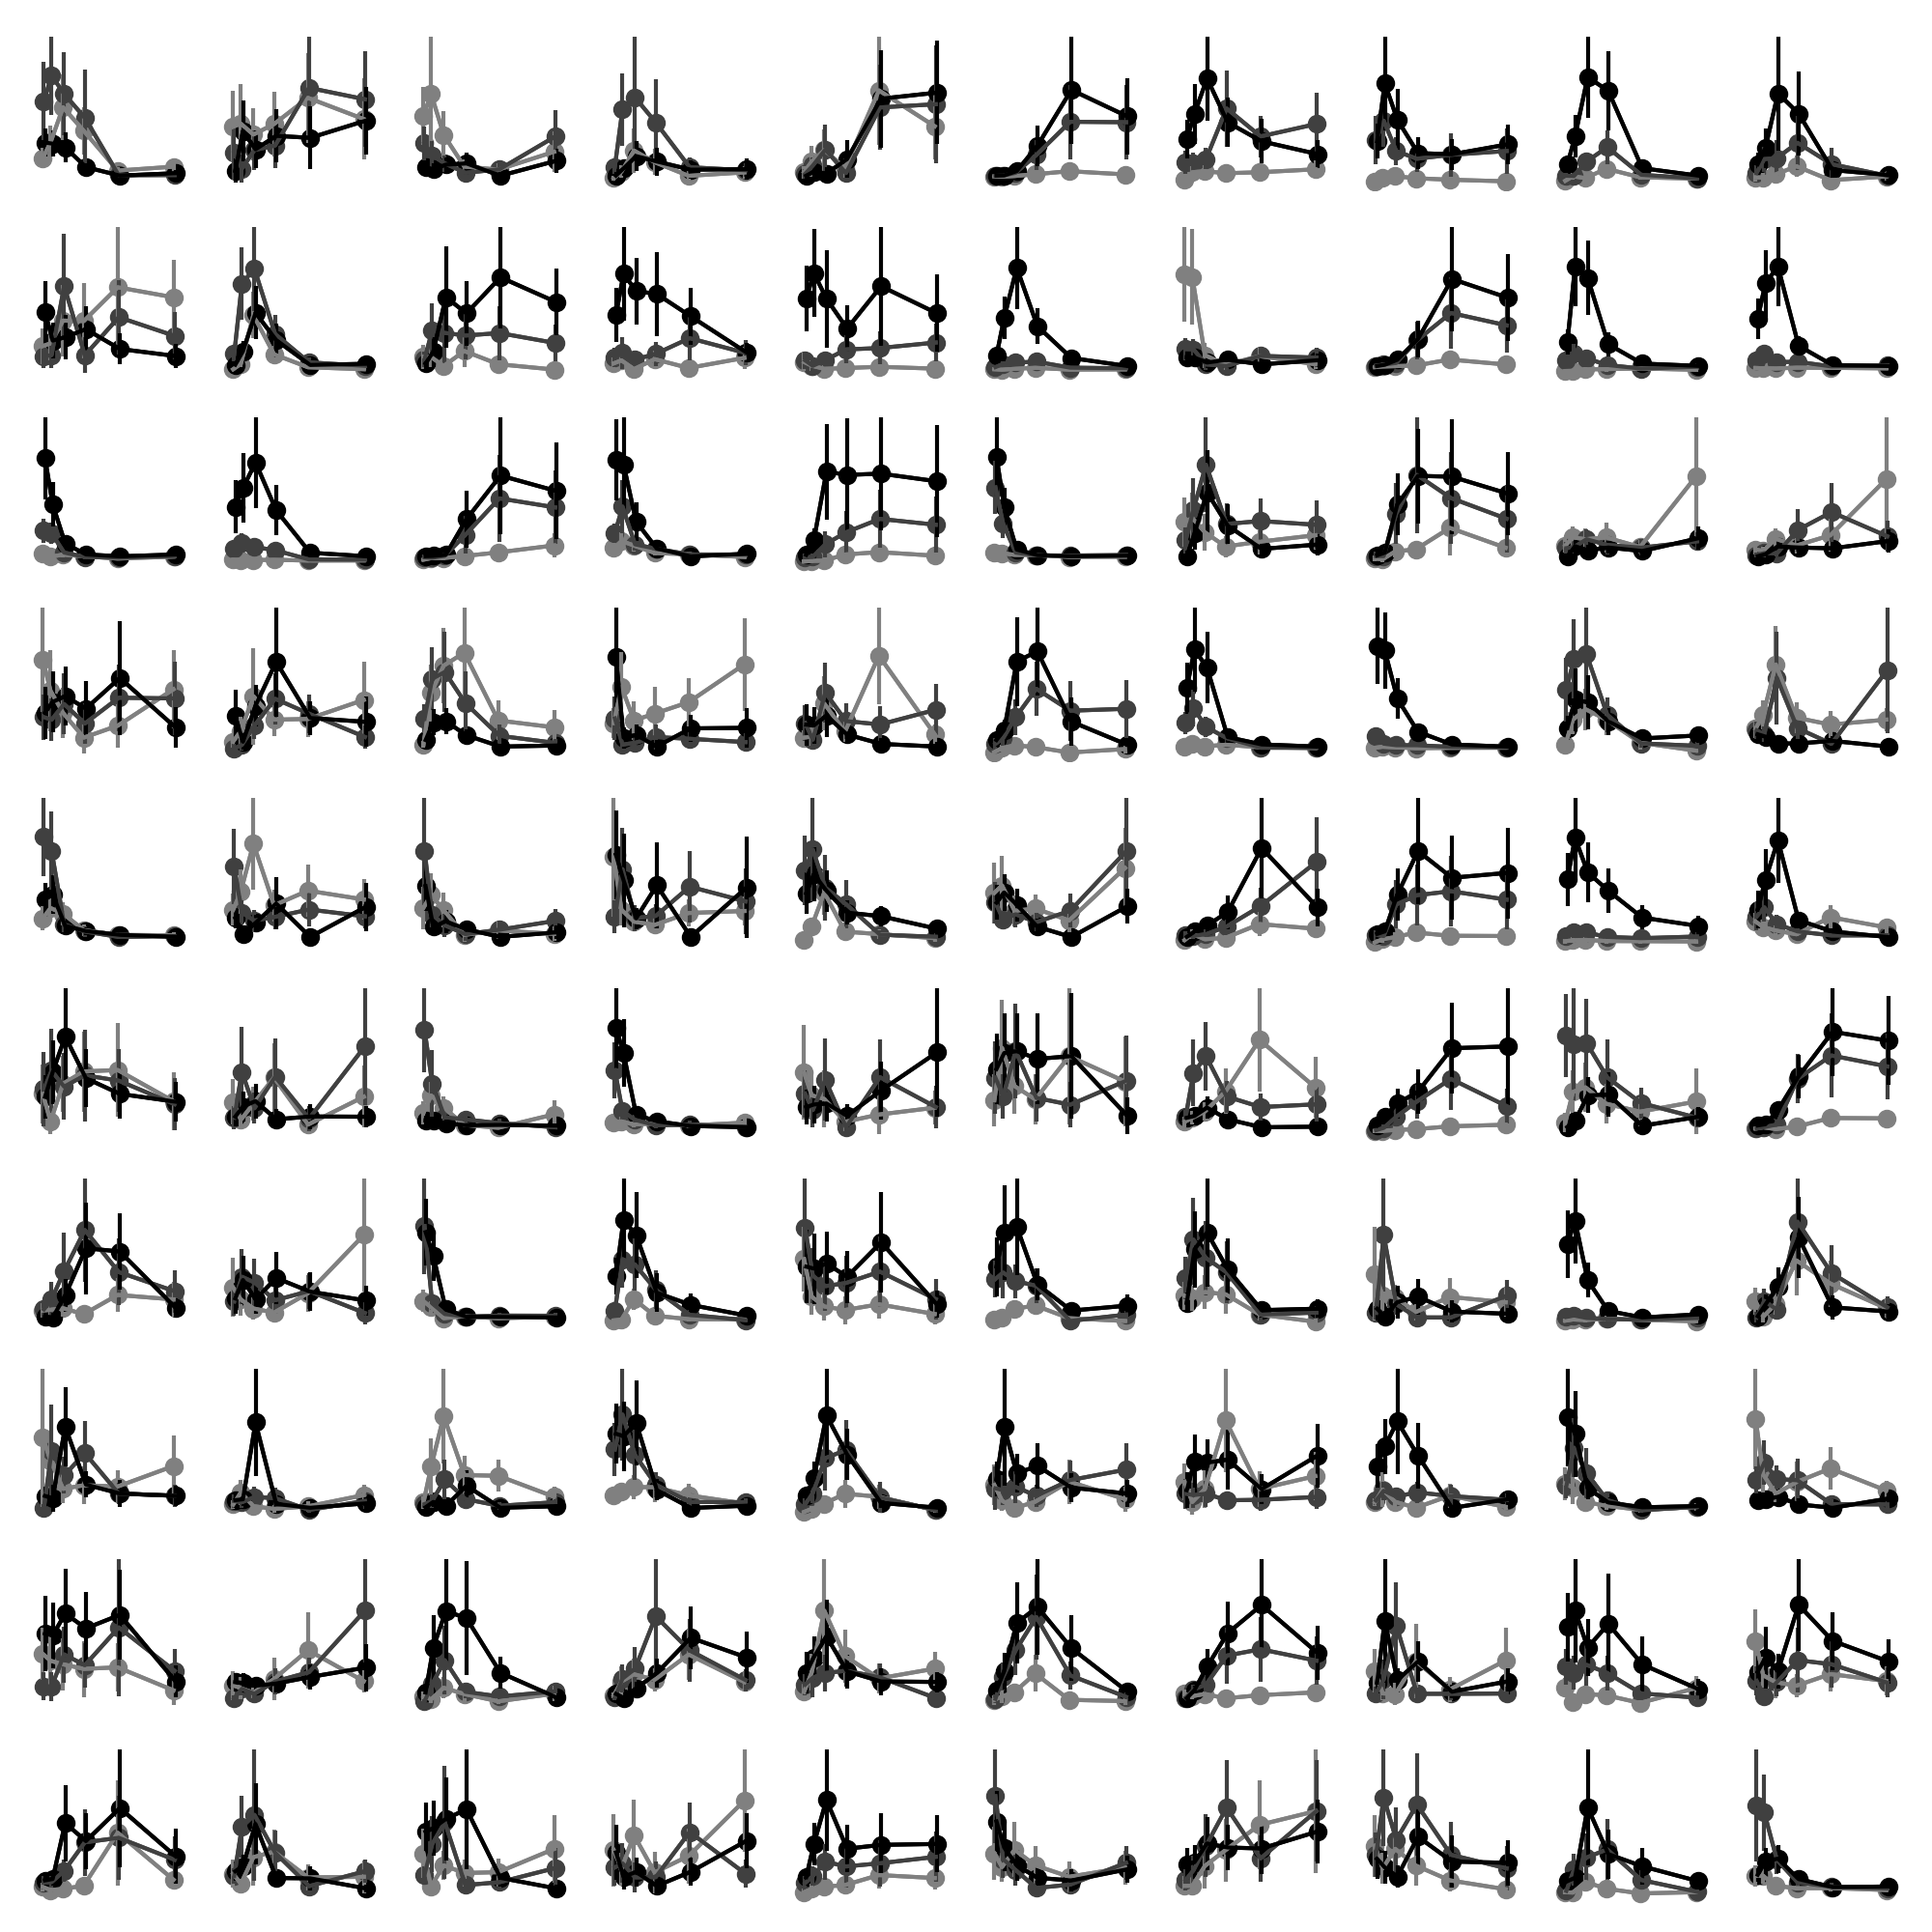

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [228]:
plt.close('all')
reload(ut)
c_l23 = np.array(((0.5,0.5,0.5),(0.25,0.25,0.25),(0,0,0)))
irun = 0
ialign = 0
itype = 0
iexpt = 12
plt.figure(figsize=(10,10))
for iroi in range(100):
    this_rs = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi],-1)
    mn = np.nanmean(this_rs)
    this_rs = this_rs/mn
    this_rs_sem = np.sqrt(np.nansum(rs_sem[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi]**2,-1))/8/mn
    deltas = [-1,0,1]
    # for iicontrast,icontrast in enumerate([1,3,5]):
    #     plt.errorbar(modal_uparam[0]+deltas[iicontrast],this_rs[:,icontrast],this_rs_sem[:,icontrast])
    plt.subplot(10,10,iroi+1)
    ut.plot_sem_errorbars_hillel(modal_uparam[0],this_rs[:,[1,3,5]].T,this_rs_sem[:,[1,3,5]].T,delta=0.3,colors=c_l23)
#     plt.ylabel('event rate/mean event rate')
#     plt.xlabel('size ($^o$)')
    plt.axis('off')
    ut.erase_top_right()
plt.tight_layout()

#     plt.savefig('figures/example_pc_neuron_expt_%d_roi_%d.eps'%(iexpt,iroi))
    

<IPython.core.display.Javascript object>


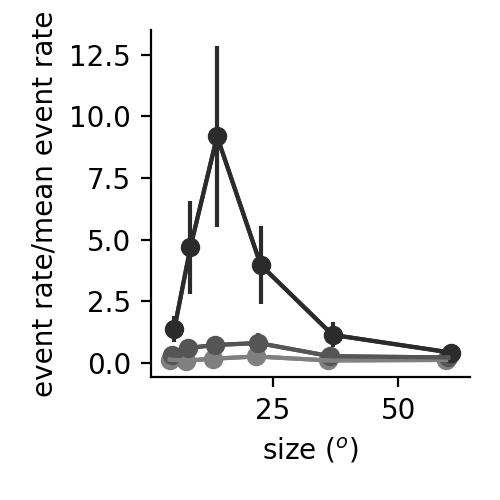

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


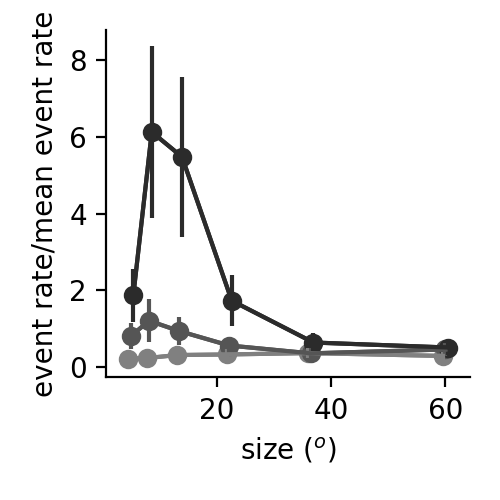

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


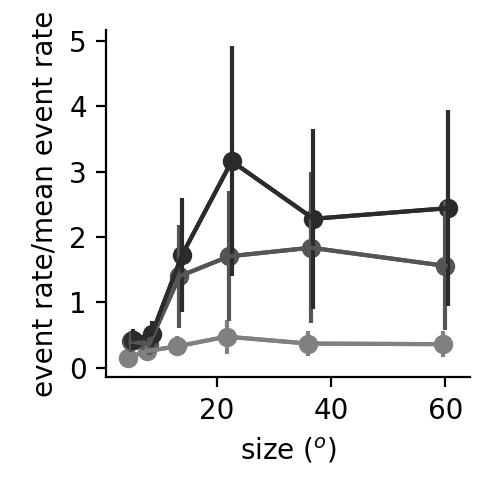

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


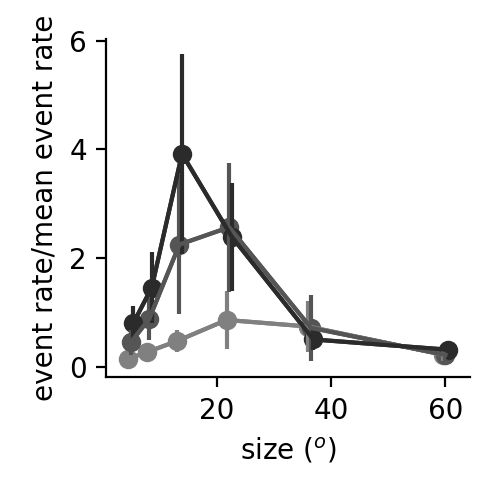

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [28]:
reload(ut)
# c_l23 = np.array(((0.5,0.5,0.5),(0.25,0.25,0.25),(0,0,0)))
irun = 0
ialign = 0
itype = 0
iexpt = 12
for iroi in [15,18,47,74]:
    this_rs = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi],-1)
    mn = np.nanmean(this_rs)
    this_rs = this_rs/mn
    this_rs_sem = np.sqrt(np.nansum(rs_sem[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)][iroi]**2,-1))/8/mn
    deltas = [-1,0,1]
    plt.figure(figsize=(2.5,2.5))
    # for iicontrast,icontrast in enumerate([1,3,5]):
    #     plt.errorbar(modal_uparam[0]+deltas[iicontrast],this_rs[:,icontrast],this_rs_sem[:,icontrast])

    ut.plot_sem_errorbars_hillel(modal_uparam[0],this_rs[:,[1,3,5]].T,this_rs_sem[:,[1,3,5]].T,delta=0.3,colors=c_l23)
    plt.ylabel('event rate/mean event rate')
    plt.xlabel('size ($^o$)')
    plt.tight_layout()
    ut.erase_top_right()
    plt.savefig('figures/example_pc_neuron_expt_%d_roi_%d.eps'%(iexpt,iroi))
    

<IPython.core.display.Javascript object>


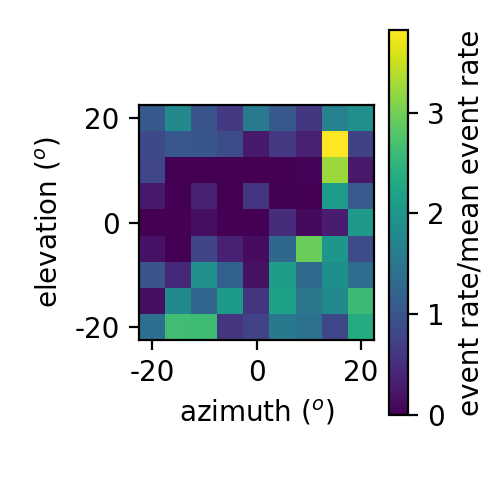

<IPython.core.display.Javascript object>


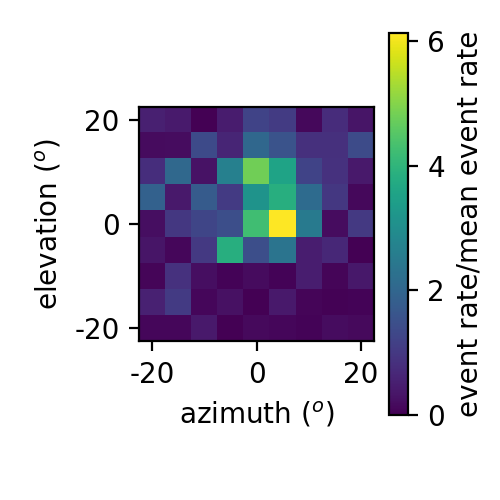

In [183]:
iexpt = 11
for iroi in [57,58]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_ret[0][3][iexpt][iroi,:,:,8:-8].mean(-1)
    plt.imshow(data/np.nanmean(data))
    plt.xticks([0,4,8],[-20,0,20])
    plt.yticks([0,4,8],[20,0,-20])
    plt.ylim(8.5,-0.5)
    plt.xlabel('azimuth ($^o$)')
    plt.ylabel('elevation ($^o$)')
    plt.colorbar().set_label('event rate/mean event rate')
    plt.tight_layout()
    plt.savefig('figures/example_vip_neuron_retinotopy_expt_%d_roi_%d.eps'%(iexpt,iroi))

<IPython.core.display.Javascript object>


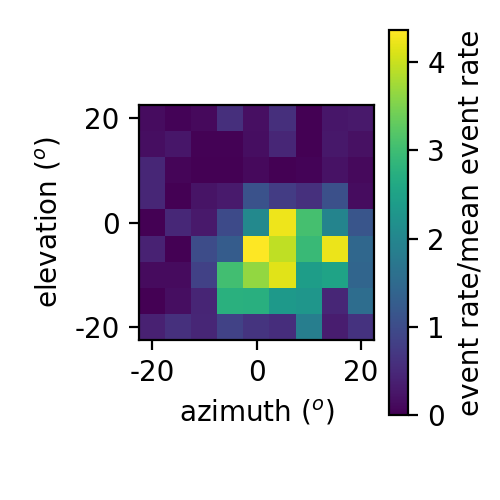

In [181]:
iexpt = 8
for iroi in [3]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_ret[0][2][iexpt][iroi,:,:,8:-8].mean(-1)
    plt.imshow(data/np.nanmean(data))
    plt.xticks([0,4,8],[-20,0,20])
    plt.yticks([0,4,8],[20,0,-20])
    plt.ylim(8.5,-0.5)
    plt.xlabel('azimuth ($^o$)')
    plt.ylabel('elevation ($^o$)')
    plt.colorbar().set_label('event rate/mean event rate')
    plt.tight_layout()
    plt.savefig('figures/example_sst_neuron_retinotopy_expt_%d_roi_%d.eps'%(iexpt,iroi))

<IPython.core.display.Javascript object>


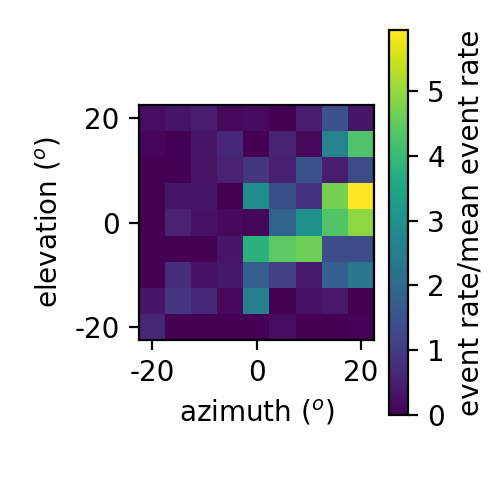

<IPython.core.display.Javascript object>


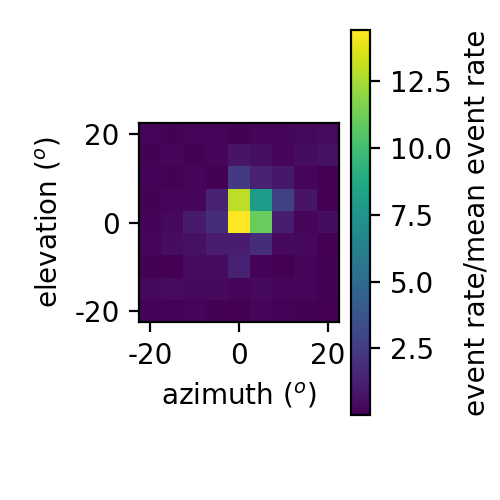

<IPython.core.display.Javascript object>


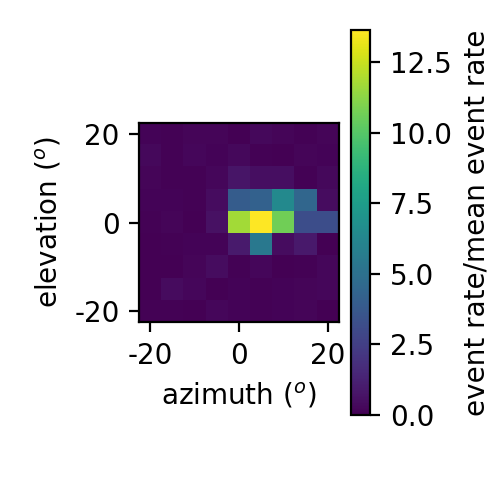

<IPython.core.display.Javascript object>


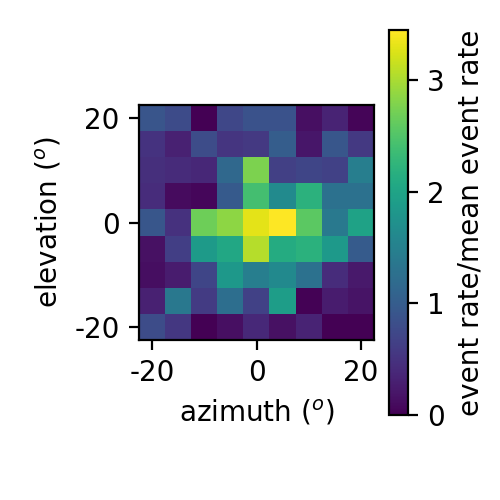

<IPython.core.display.Javascript object>


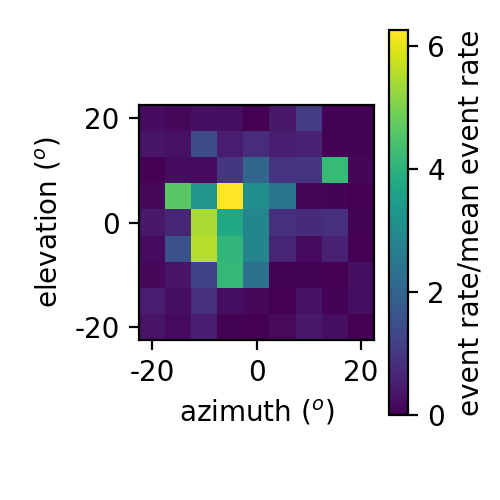

<IPython.core.display.Javascript object>


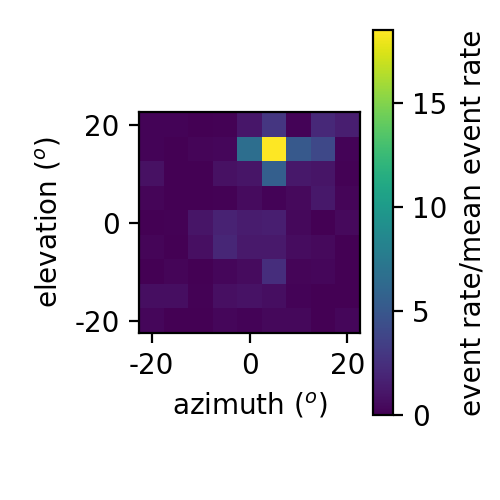

In [231]:
iexpt = 12
for iroi in [5,15,18,47,74,86]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_ret[0][1][iexpt][iroi,:,:,8:-8].mean(-1)
    plt.imshow(data/np.nanmean(data))
    plt.xticks([0,4,8],[-20,0,20])
    plt.yticks([0,4,8],[20,0,-20])
    plt.ylim(8.5,-0.5)
    plt.xlabel('azimuth ($^o$)')
    plt.ylabel('elevation ($^o$)')
    plt.colorbar().set_label('event rate/mean event rate')
    plt.tight_layout()
    plt.savefig('figures/example_pc_neuron_retinotopy_expt_%d_roi_%d.eps'%(iexpt,iroi))

In [40]:
this_ncontrast = 6
cfrac = np.linspace(1,0,this_ncontrast+1)[:-1]
c_sst_full = cfrac[:,np.newaxis]*np.array(((1,0.5,0)))
c_vip_full = cfrac[:,np.newaxis]*np.array(((1,0,1)))

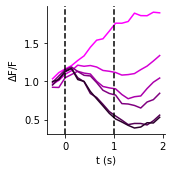

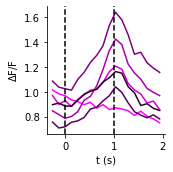

In [41]:
# c_vip_full = np.array([np.array((1,0,1))*icontrast/5 for icontrast in range(6)])
iexpt = 11
for iroi in [57,58]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_sc_sst_vip[0][1][iexpt][iroi,:,:,:,6:]
    t = (np.arange(data.shape[-1])-2)/7.75
    mn = np.nanmean(data)
    contrast_colors = plt.cm.viridis(np.linspace(0,1,6))
    data = data/mn
#     isize = 3
    for icontrast in np.arange(6):
        plt.plot(t,np.nanmean(np.nanmean(data,2),0)[icontrast],c=c_vip_full[icontrast])
#     plt.xticks([0,4,8],[-20,0,20])
#     plt.yticks([0,4,8],[20,0,-20])
#     plt.ylim(8.5,-0.5)
#     plt.xlabel('azimuth ($^o$)')
#     plt.ylabel('elevation ($^o$)')
    plt.xlabel('t (s)')
    plt.ylabel(r'$\Delta$F/F')
    plt.tight_layout()
    ut.erase_top_right()
    plt.axvline(0,c='k',linestyle='dashed')
    plt.axvline(1,c='k',linestyle='dashed')
#     plt.savefig('figures/example_vip_neuron_contrast_timecourse_expt_%d_roi_%d.eps'%(iexpt,iroi))

<IPython.core.display.Javascript object>


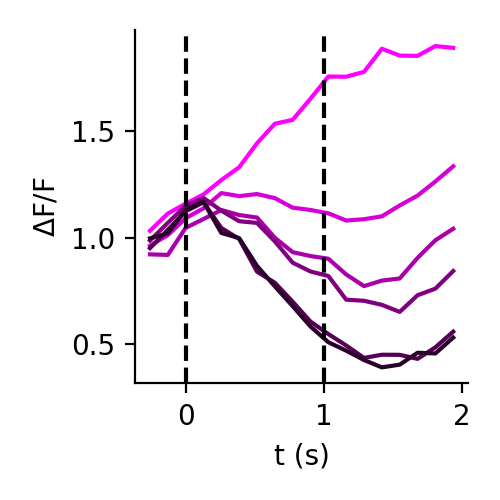

<IPython.core.display.Javascript object>


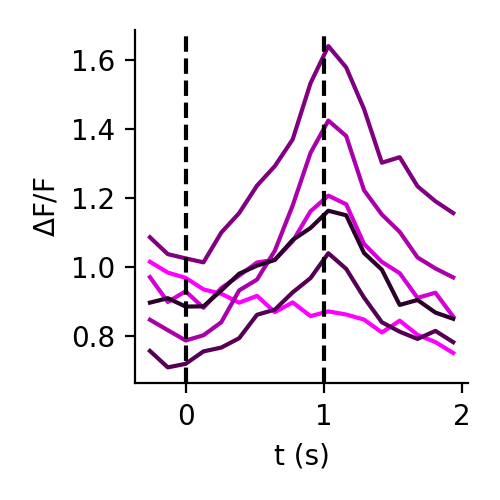

In [13]:
# c_vip_full = np.array([np.array((1,0,1))*icontrast/5 for icontrast in range(6)])
iexpt = 11
for iroi in [57,58]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_sc[0][3][iexpt][iroi,:,:,:,6:]
    t = (np.arange(data.shape[-1])-2)/7.75
    mn = np.nanmean(data)
    contrast_colors = plt.cm.viridis(np.linspace(0,1,6))
    data = data/mn
#     isize = 3
    for icontrast in np.arange(6):
        plt.plot(t,np.nanmean(np.nanmean(data,2),0)[icontrast],c=c_vip_full[icontrast])
#     plt.xticks([0,4,8],[-20,0,20])
#     plt.yticks([0,4,8],[20,0,-20])
#     plt.ylim(8.5,-0.5)
#     plt.xlabel('azimuth ($^o$)')
#     plt.ylabel('elevation ($^o$)')
    plt.xlabel('t (s)')
    plt.ylabel(r'$\Delta$F/F')
    plt.tight_layout()
    ut.erase_top_right()
    plt.axvline(0,c='k',linestyle='dashed')
    plt.axvline(1,c='k',linestyle='dashed')
#     plt.savefig('figures/example_vip_neuron_contrast_timecourse_expt_%d_roi_%d.eps'%(iexpt,iroi))

<IPython.core.display.Javascript object>


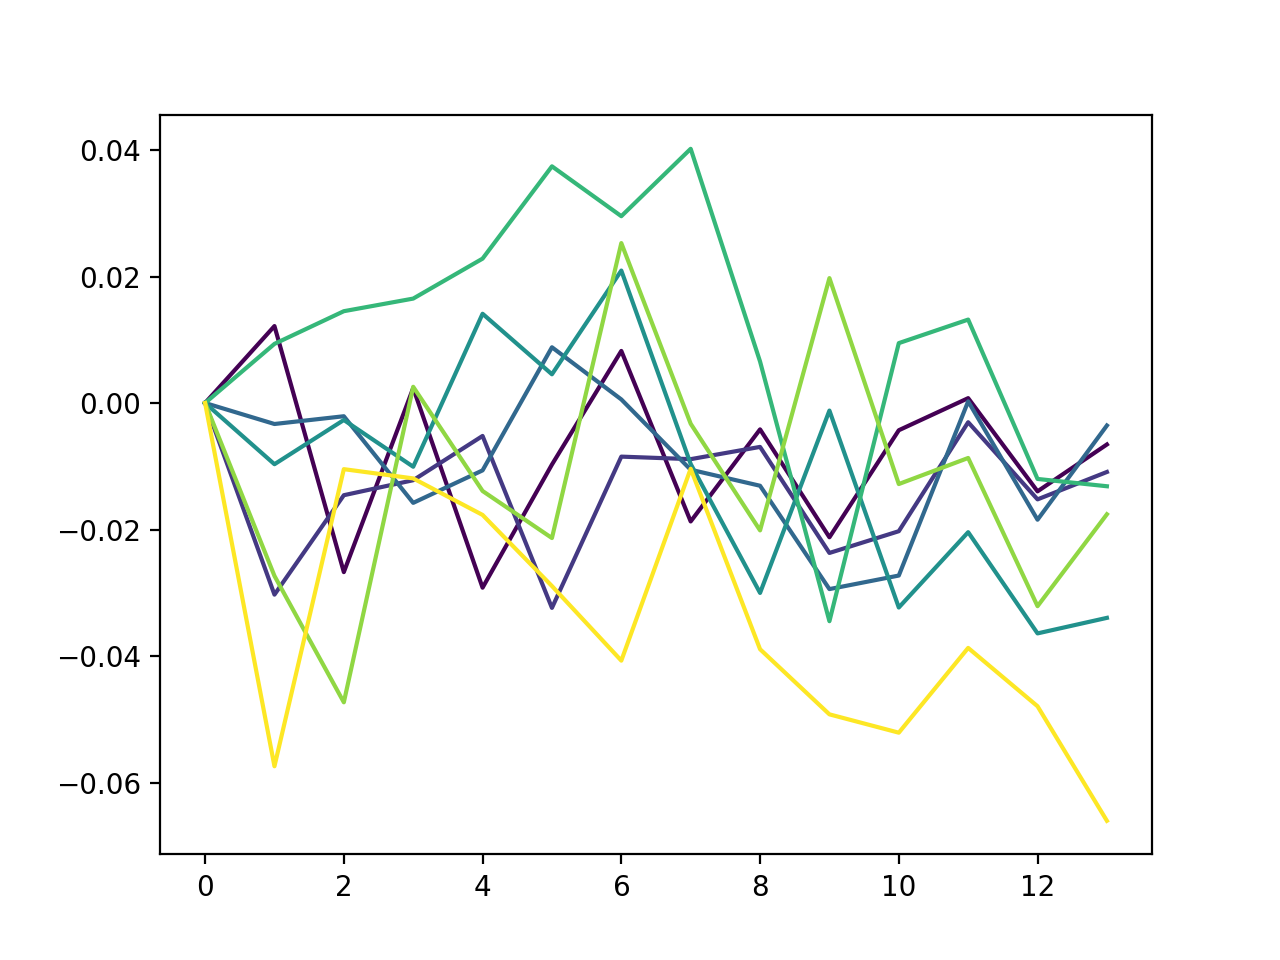

<IPython.core.display.Javascript object>


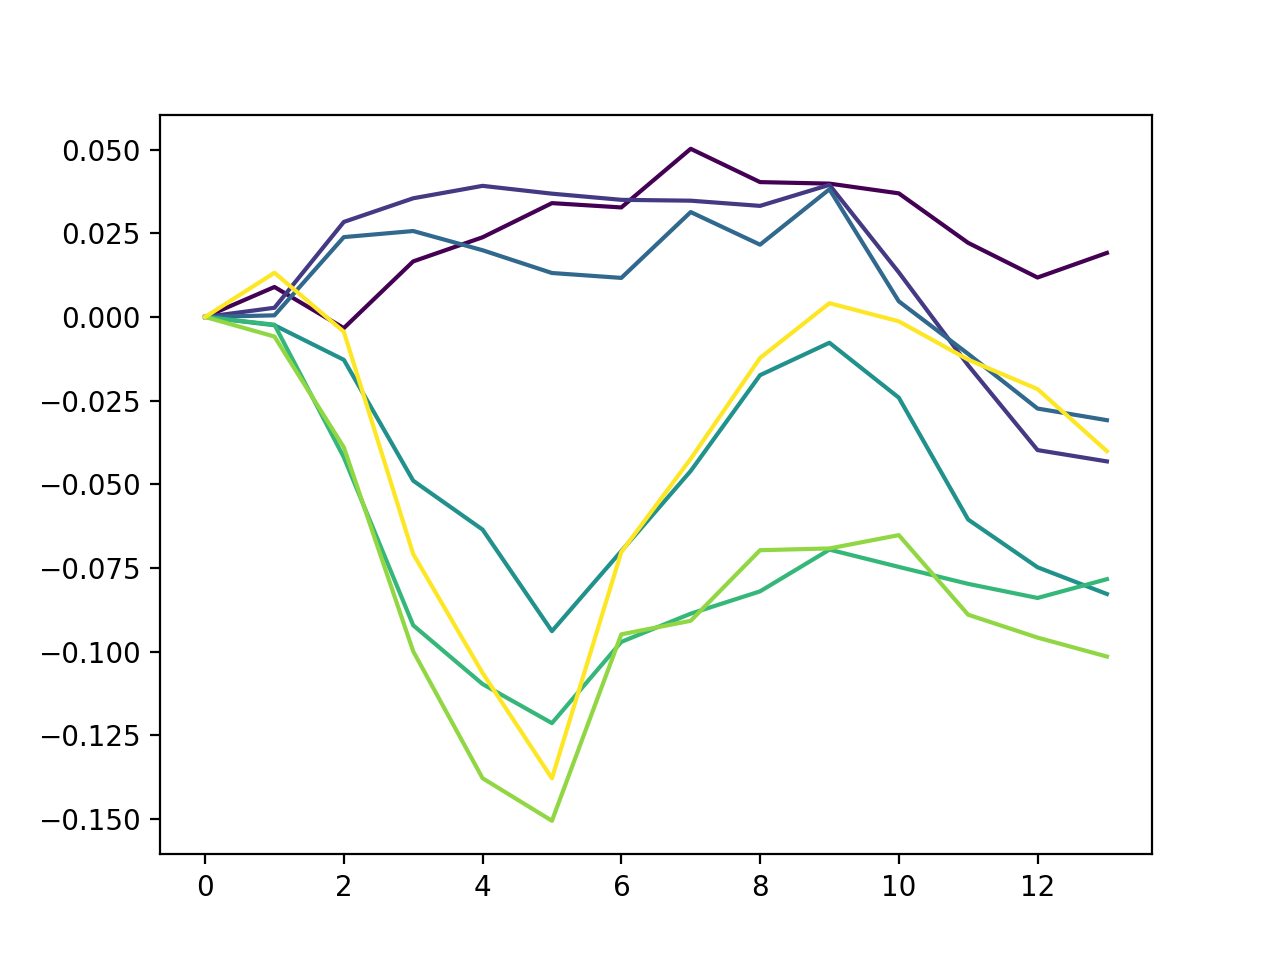

<IPython.core.display.Javascript object>


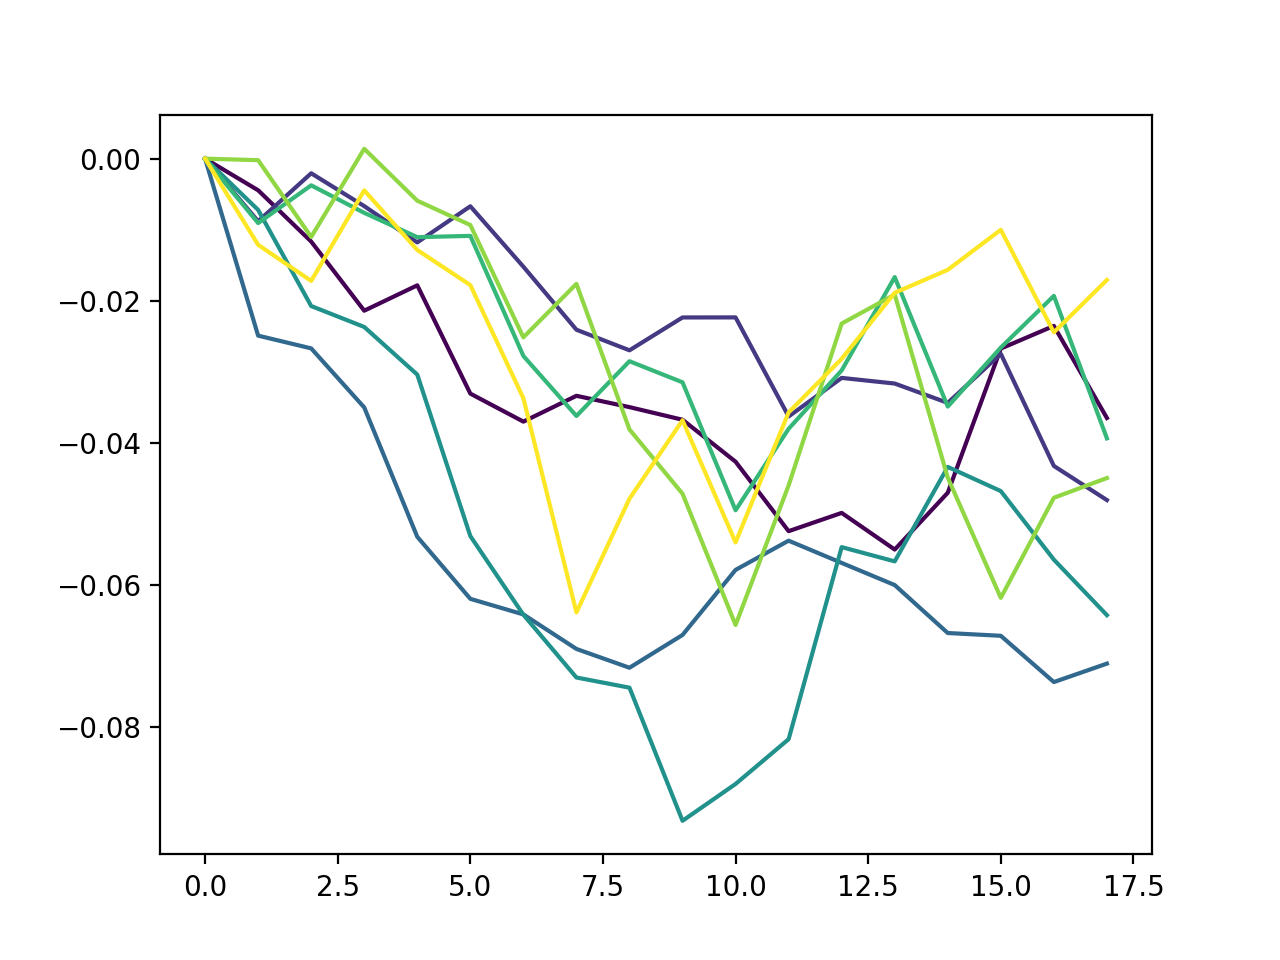

<IPython.core.display.Javascript object>


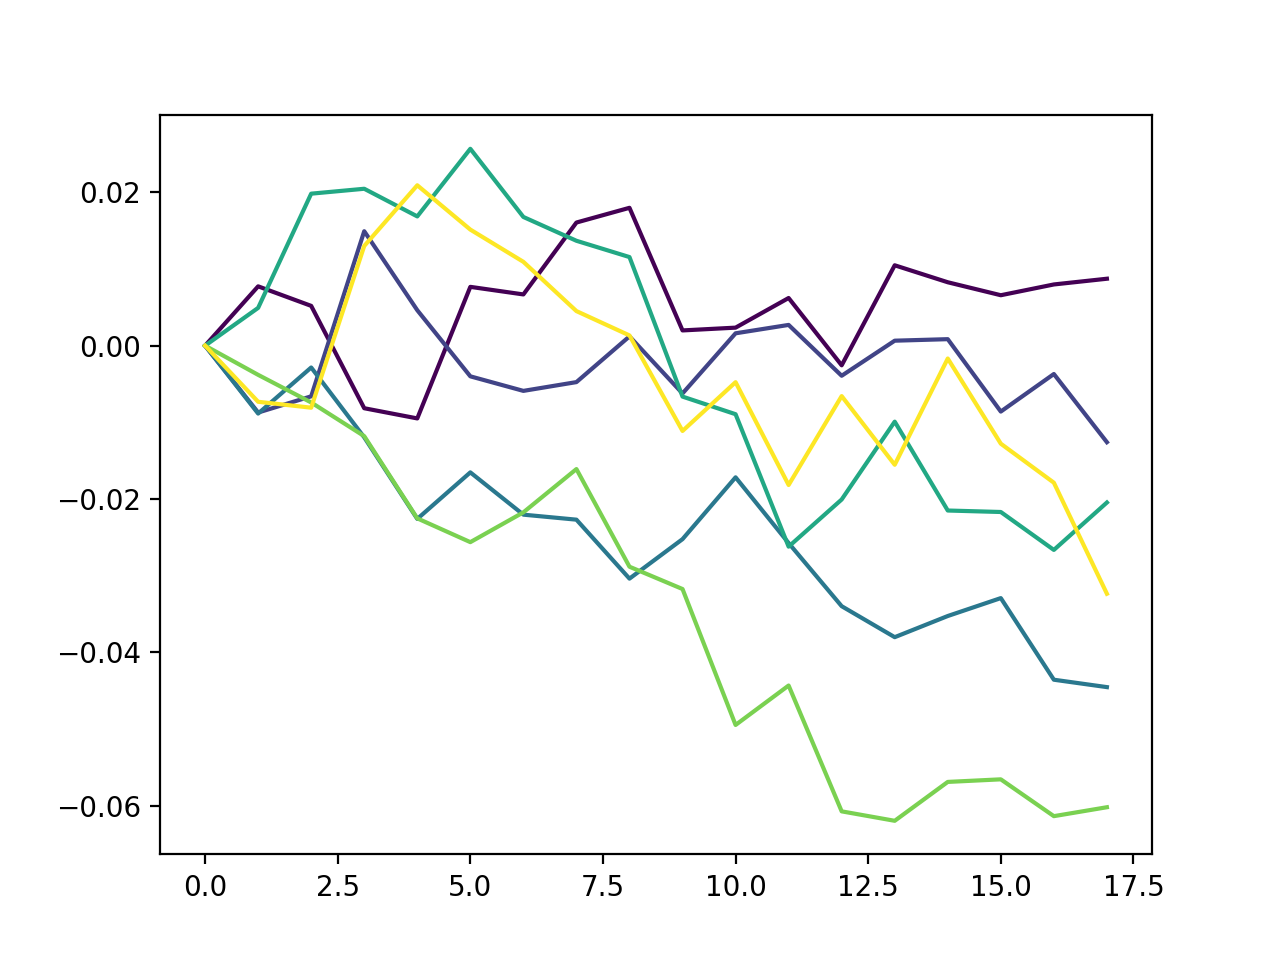

<IPython.core.display.Javascript object>


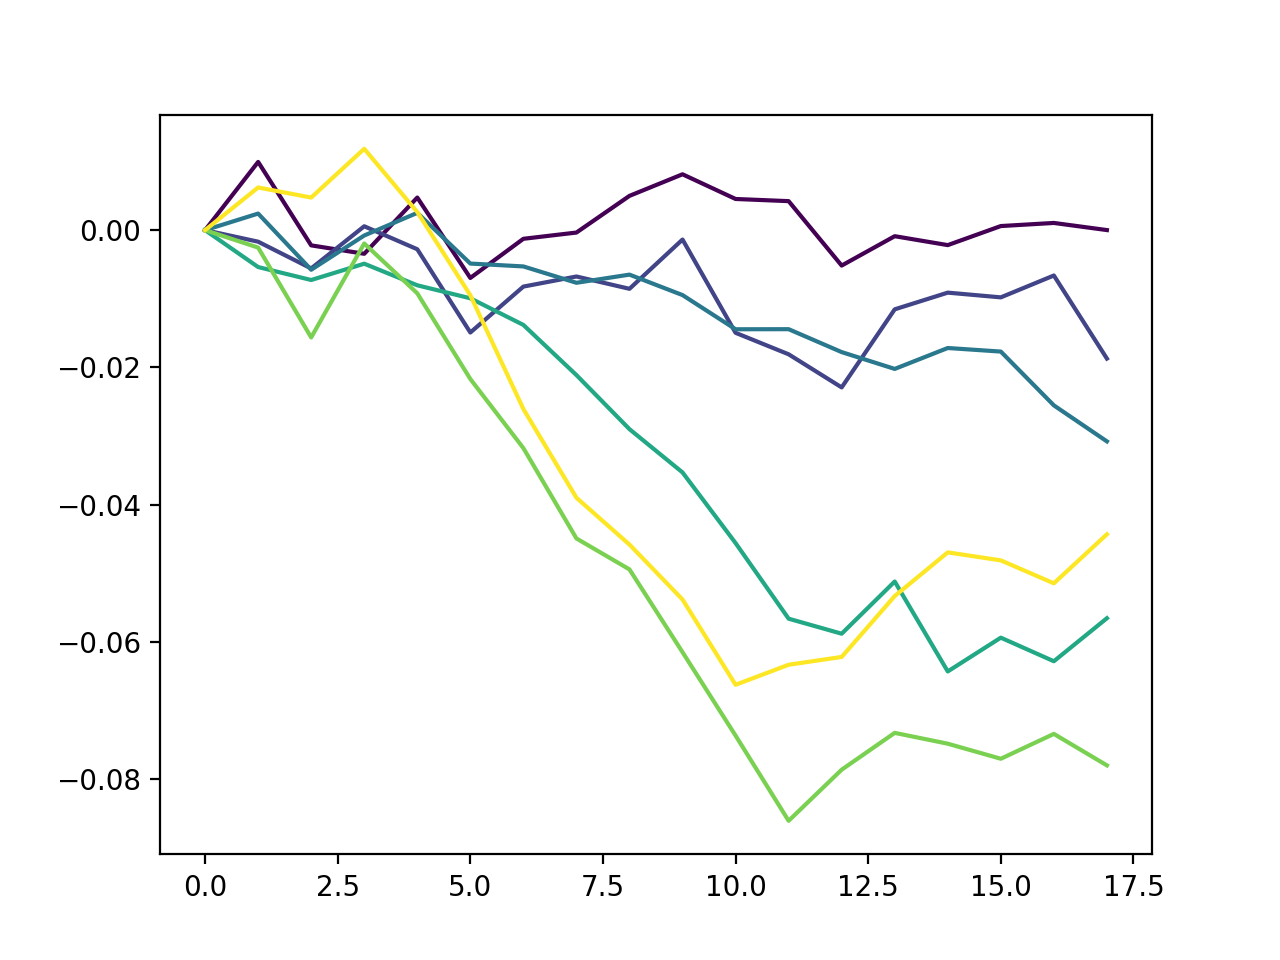

<IPython.core.display.Javascript object>


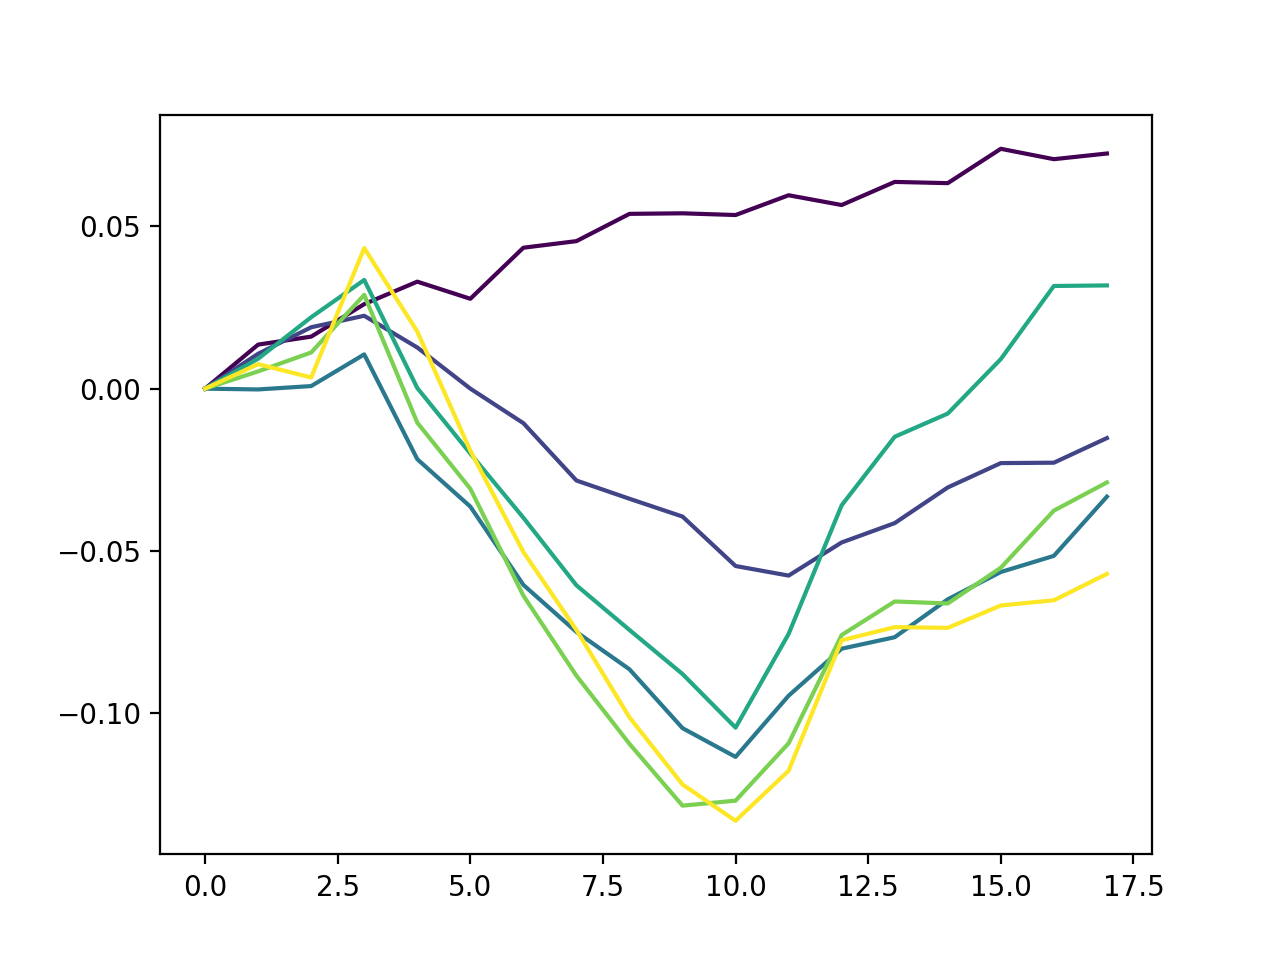

<IPython.core.display.Javascript object>


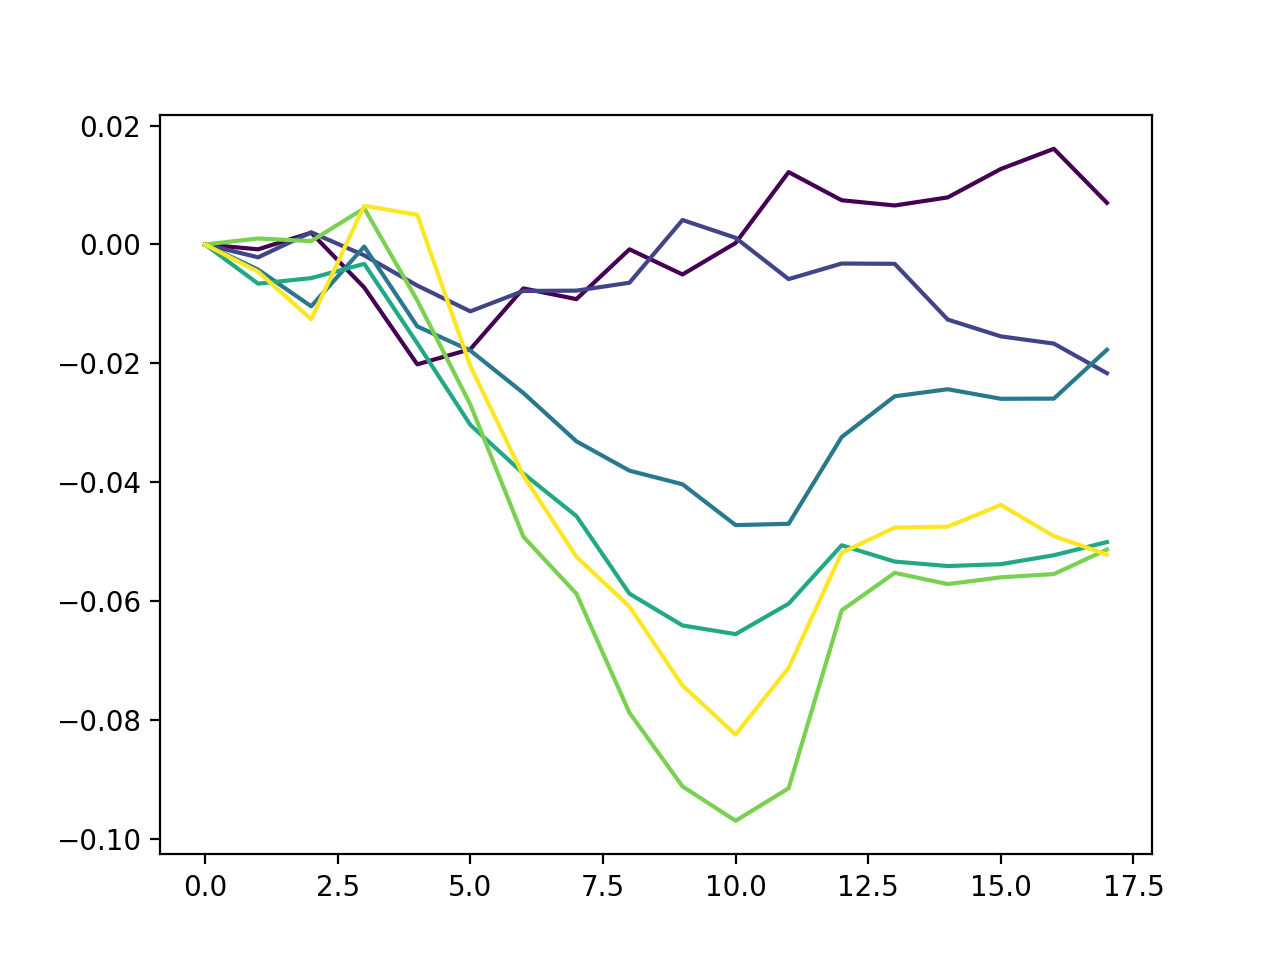

<IPython.core.display.Javascript object>


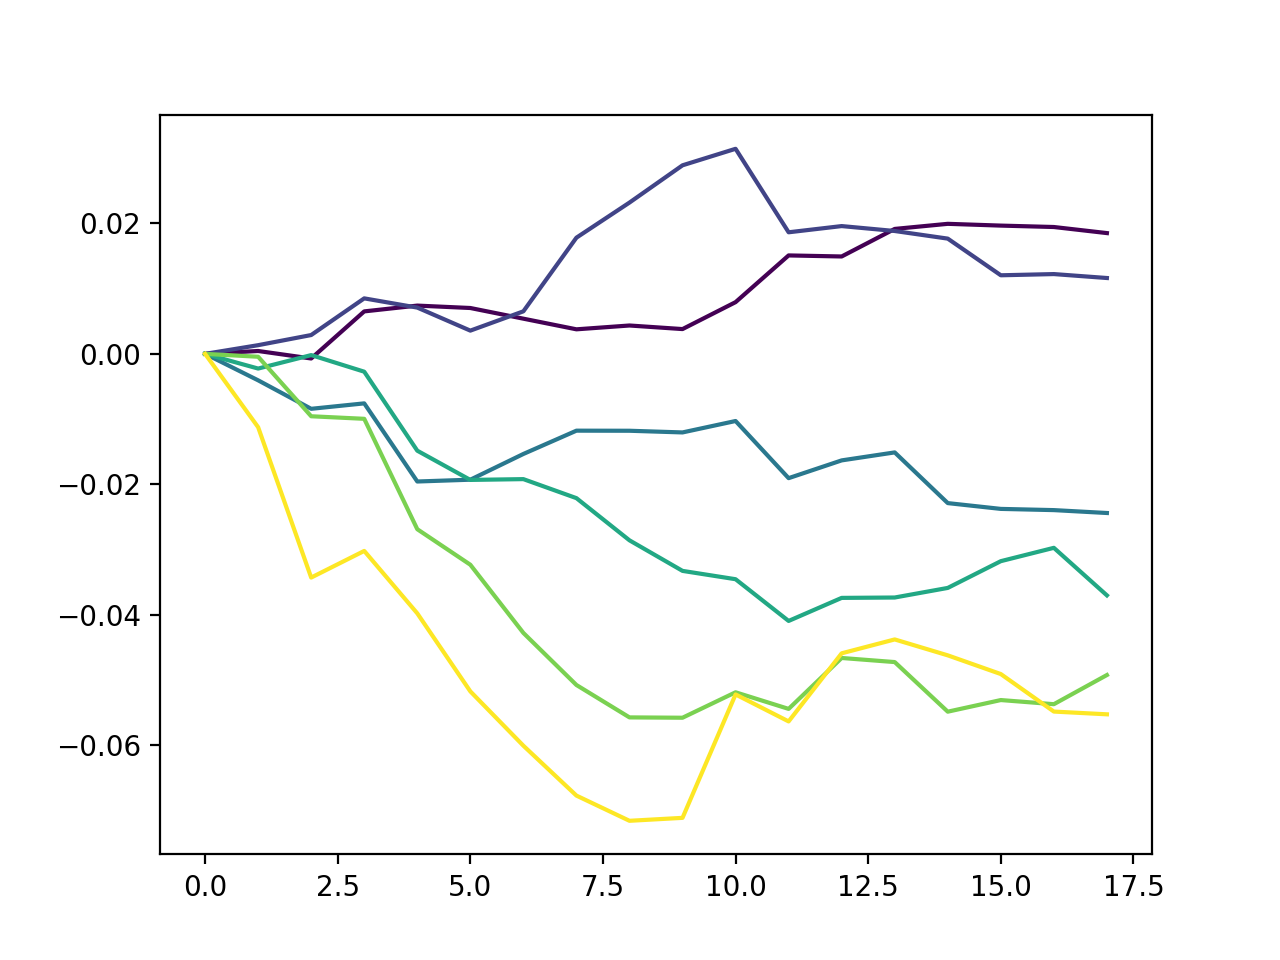

<IPython.core.display.Javascript object>


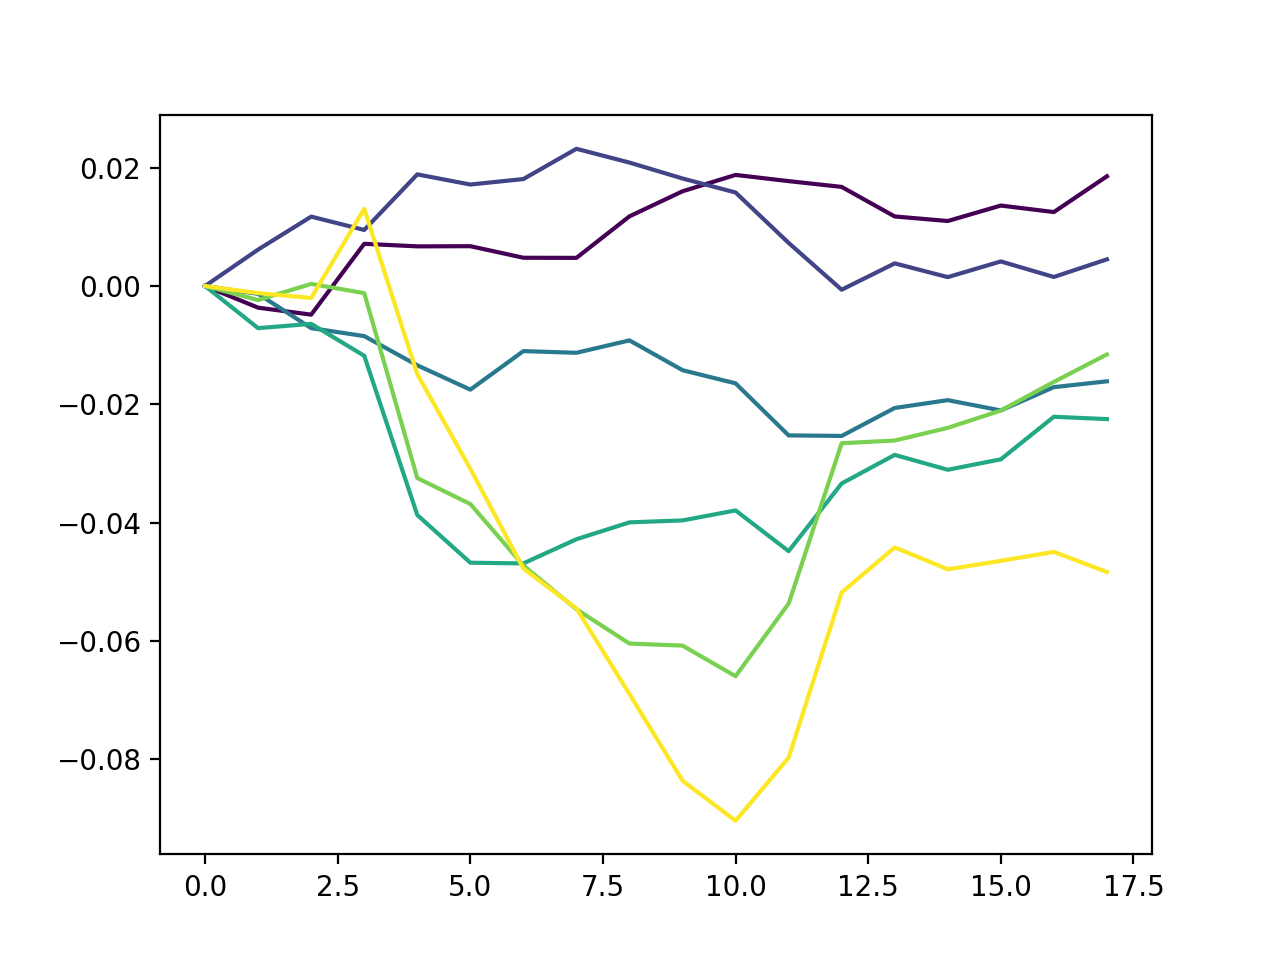

<IPython.core.display.Javascript object>


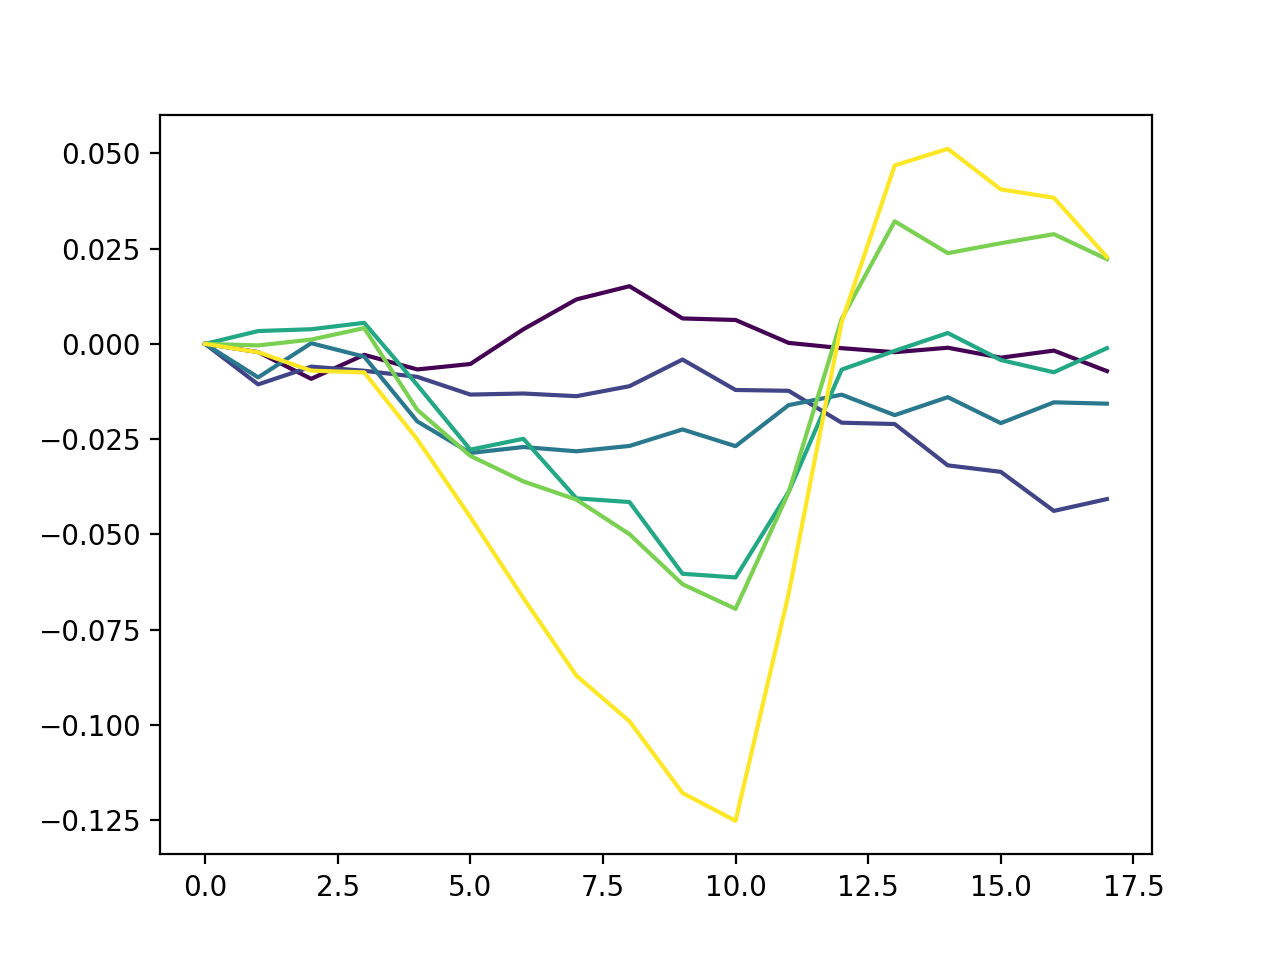

In [34]:
for iexpt in range(len(tunings_sc[0][1])):
    isize = 4
    if not tunings_sc[0][1][iexpt] is None:
        this_data = tunings_sc[0][1][iexpt][:,:,:,:,6:]
        colors = plt.cm.viridis(np.linspace(0,1,this_data.shape[2]))
        contrast_suppressed = (np.nanmean(np.nanmean(np.nanmean(this_data[:,:,1:,:,5],1),1),1) < np.nanmean(np.nanmean(np.nanmean(this_data[:,:,1:,:,0],1),1),1))
        plt.figure()
        for icontrast in range(colors.shape[0]):
            to_plot = np.nanmean(np.nanmean(this_data[contrast_suppressed],3),0)[isize,icontrast,:]
            plt.plot(to_plot-to_plot[0],c=colors[icontrast])


<IPython.core.display.Javascript object>


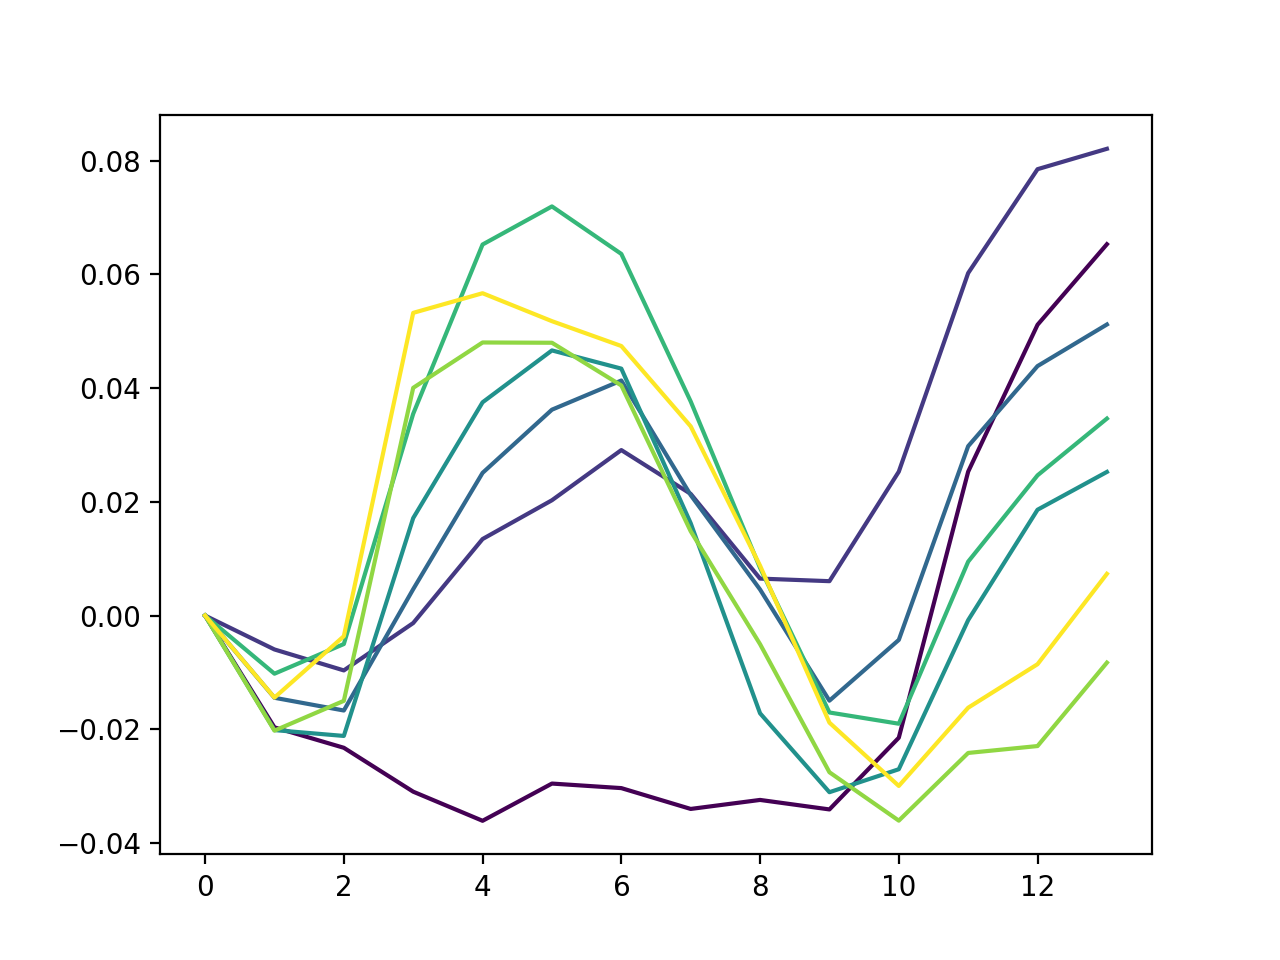

<IPython.core.display.Javascript object>


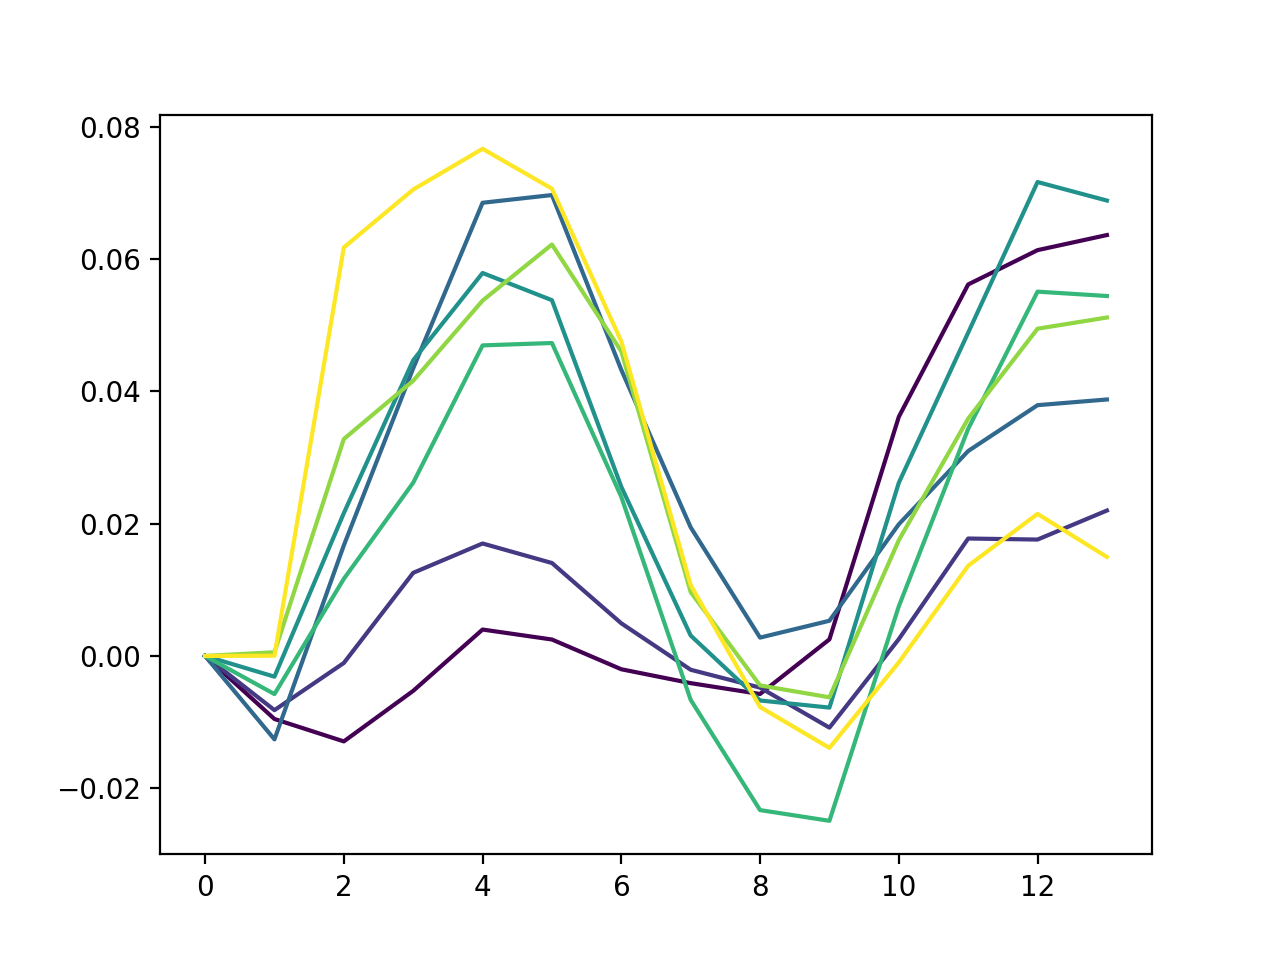

<IPython.core.display.Javascript object>


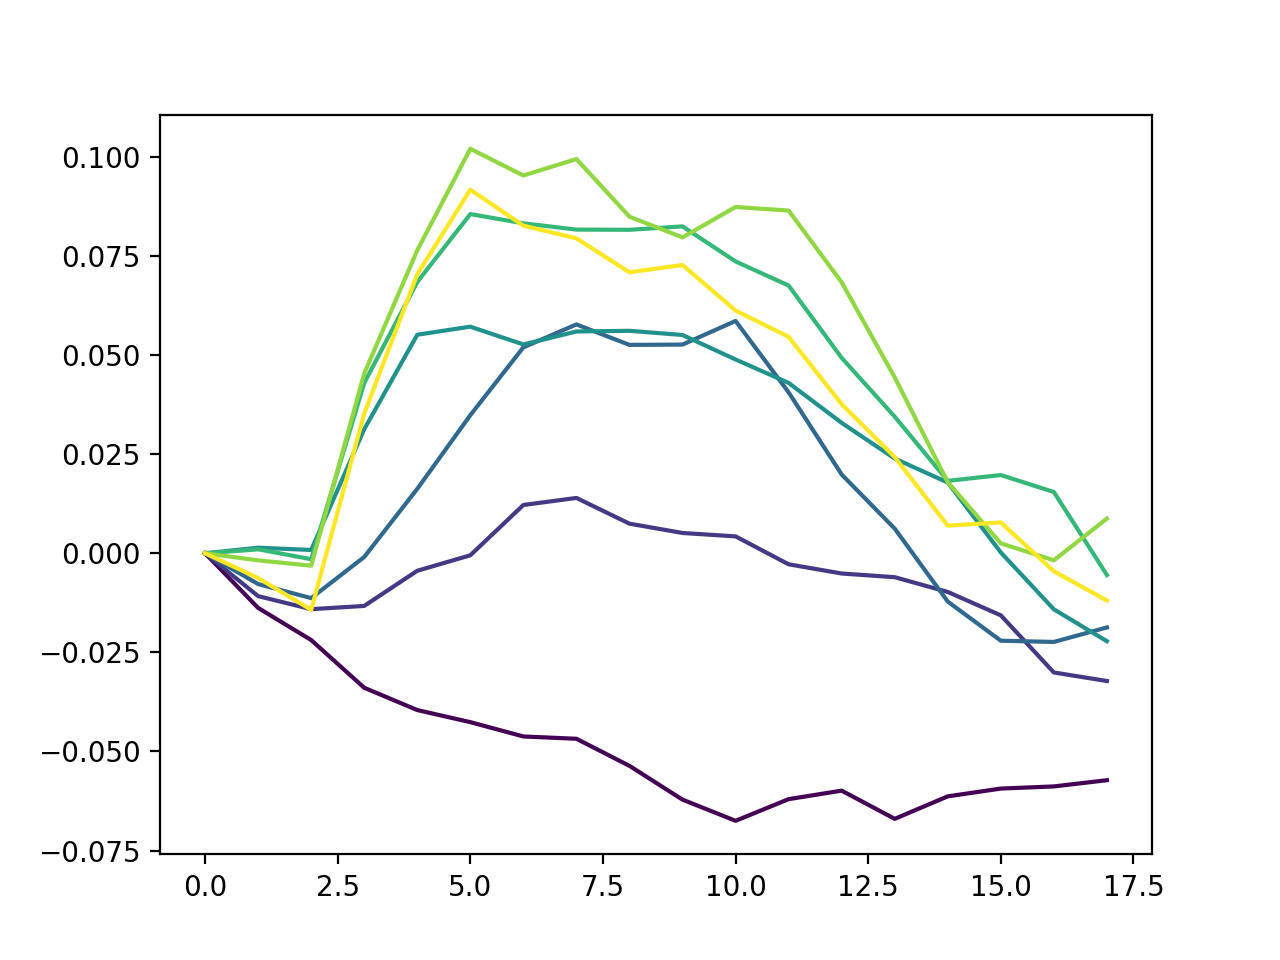

<IPython.core.display.Javascript object>


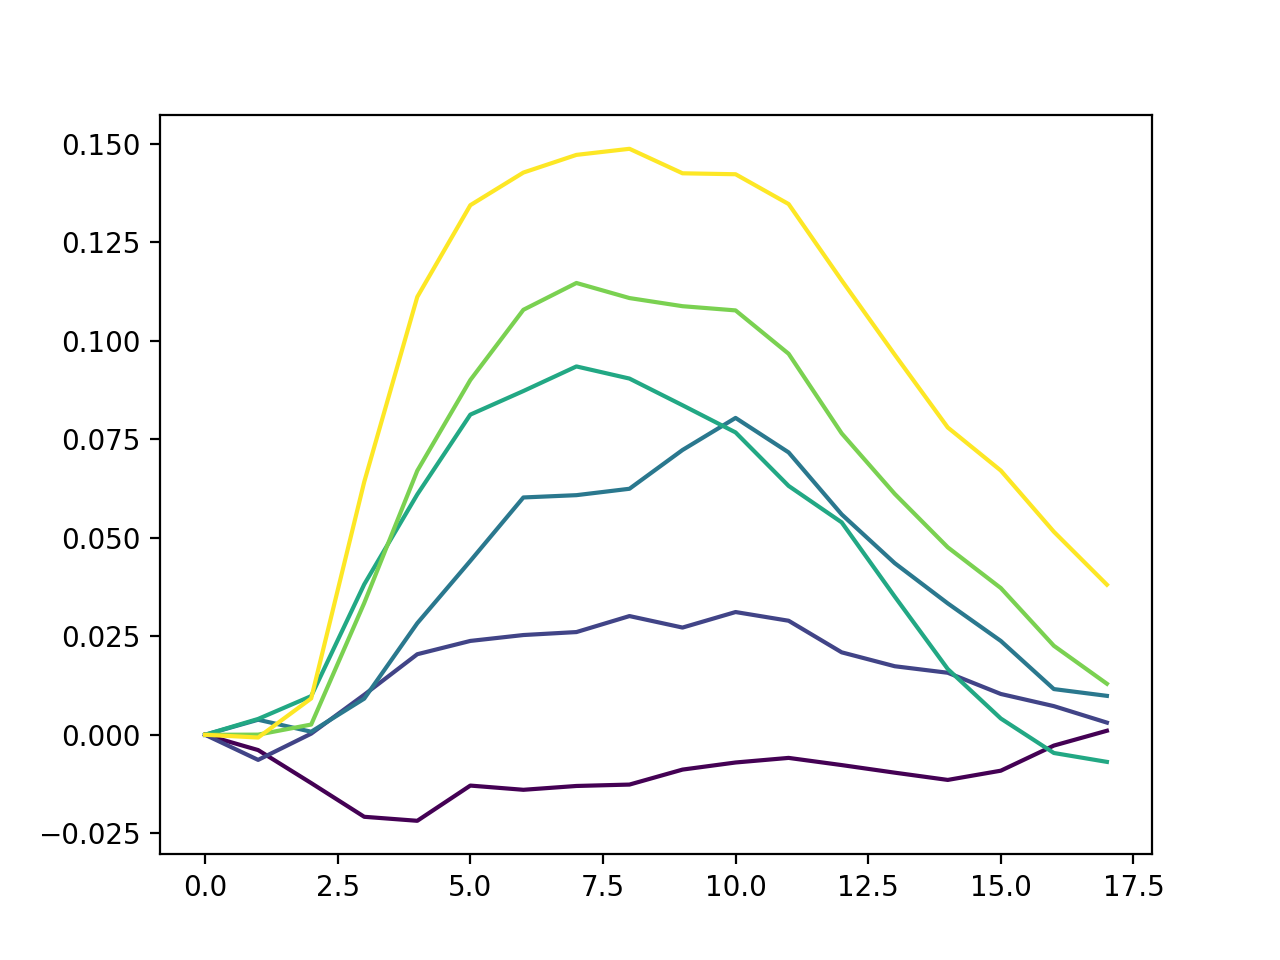

<IPython.core.display.Javascript object>


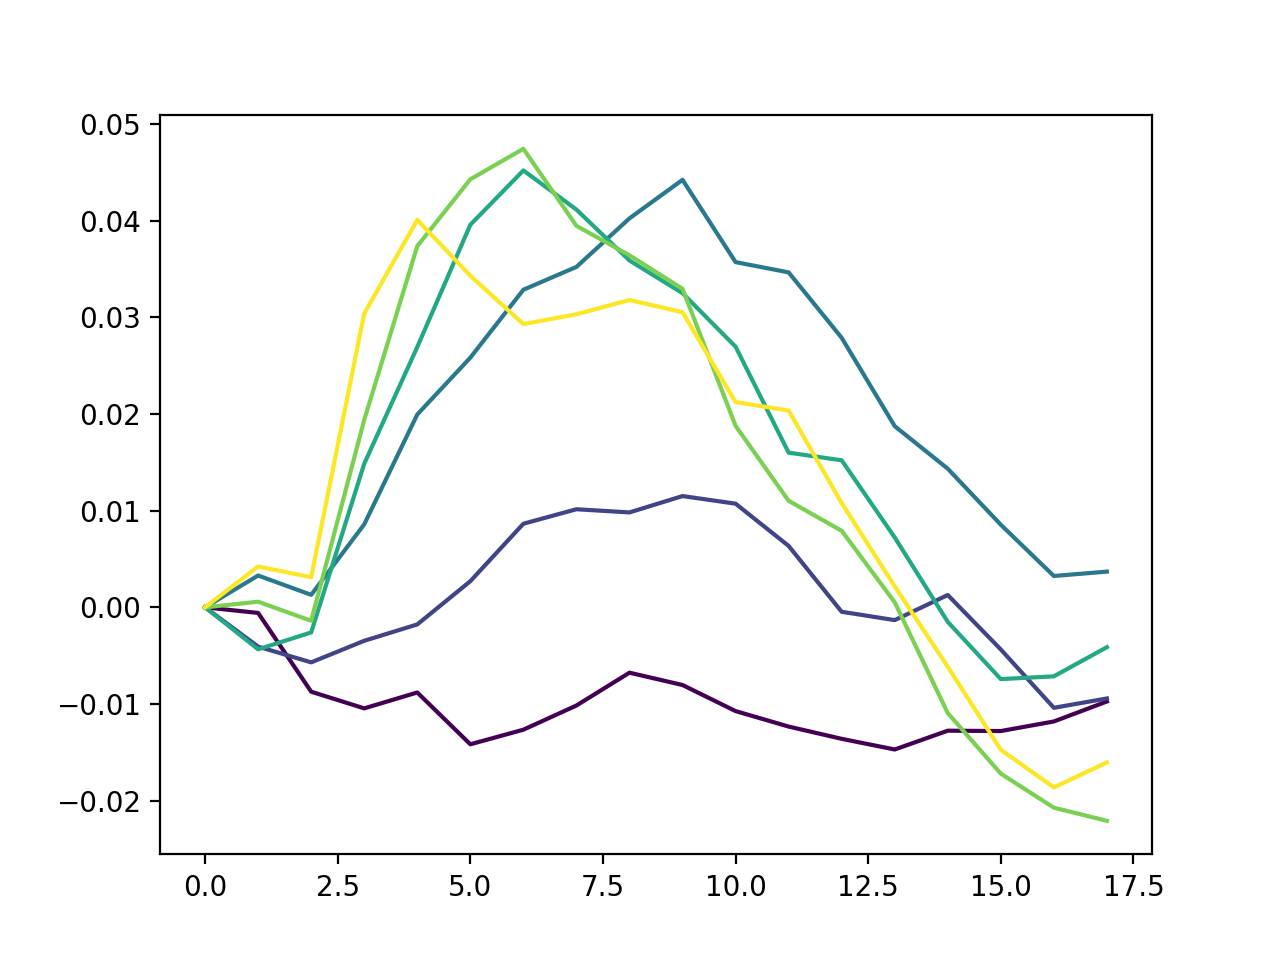

<IPython.core.display.Javascript object>


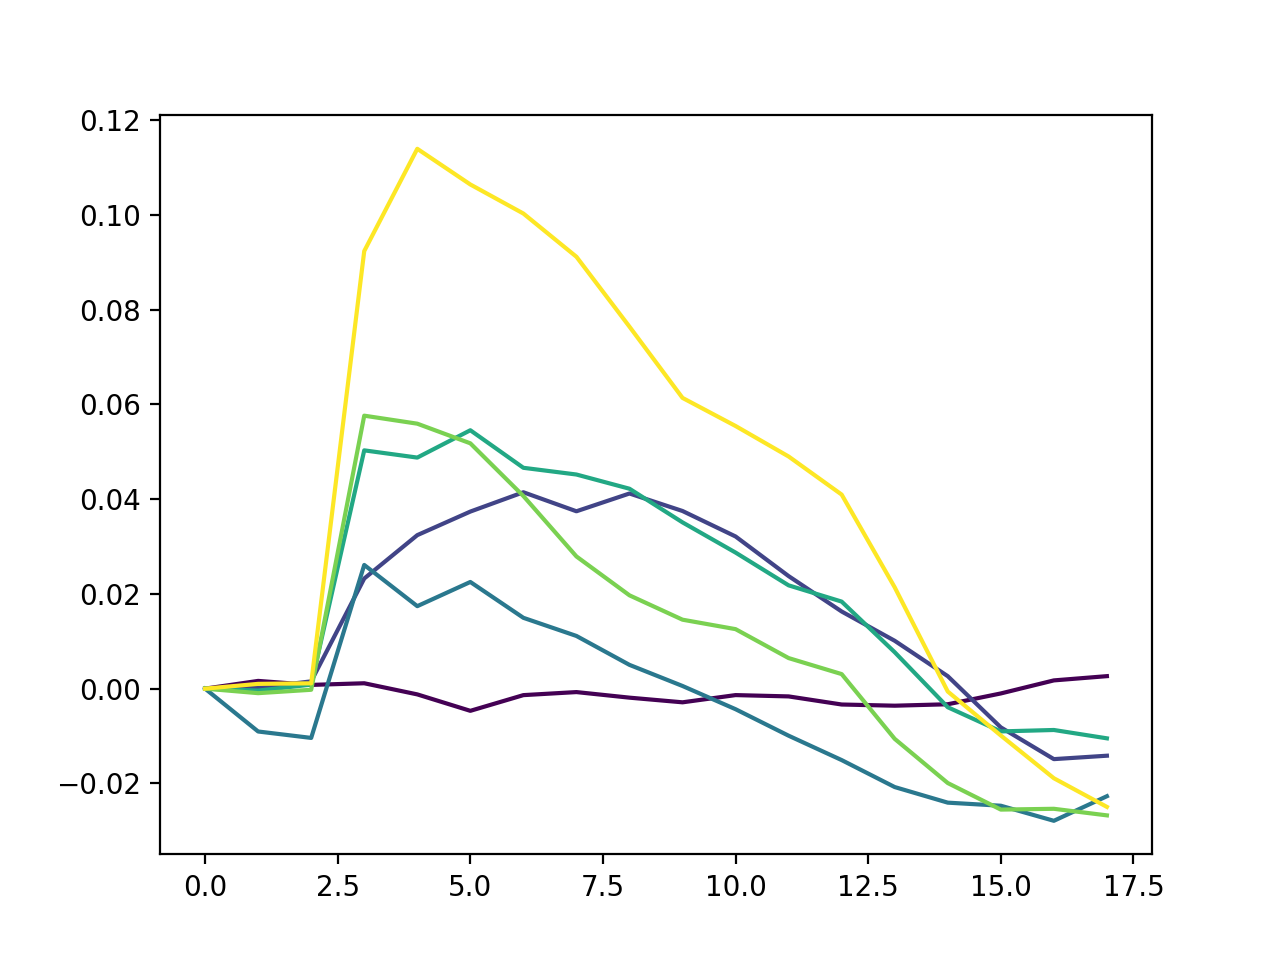

<IPython.core.display.Javascript object>


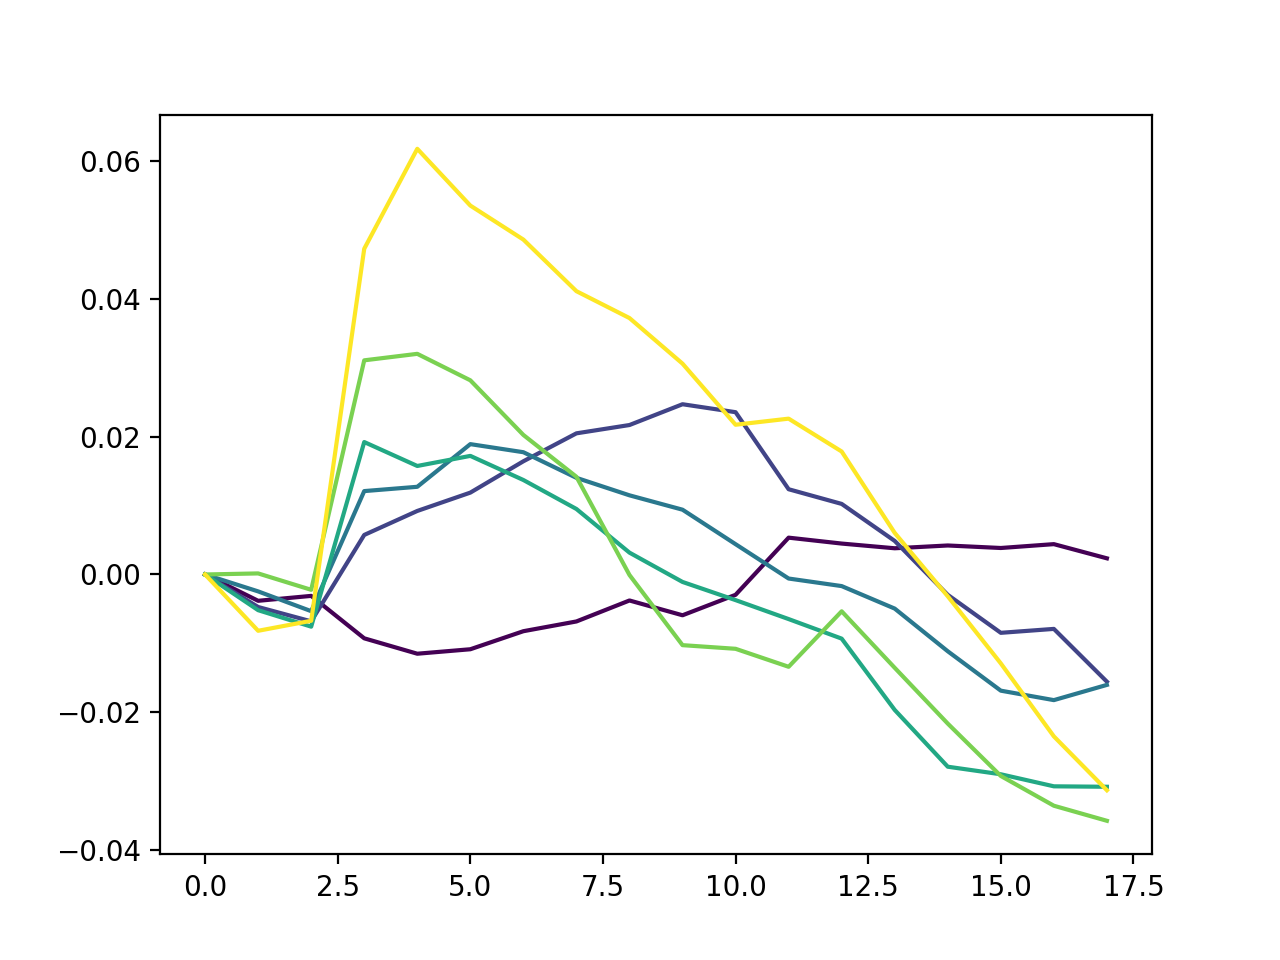

<IPython.core.display.Javascript object>


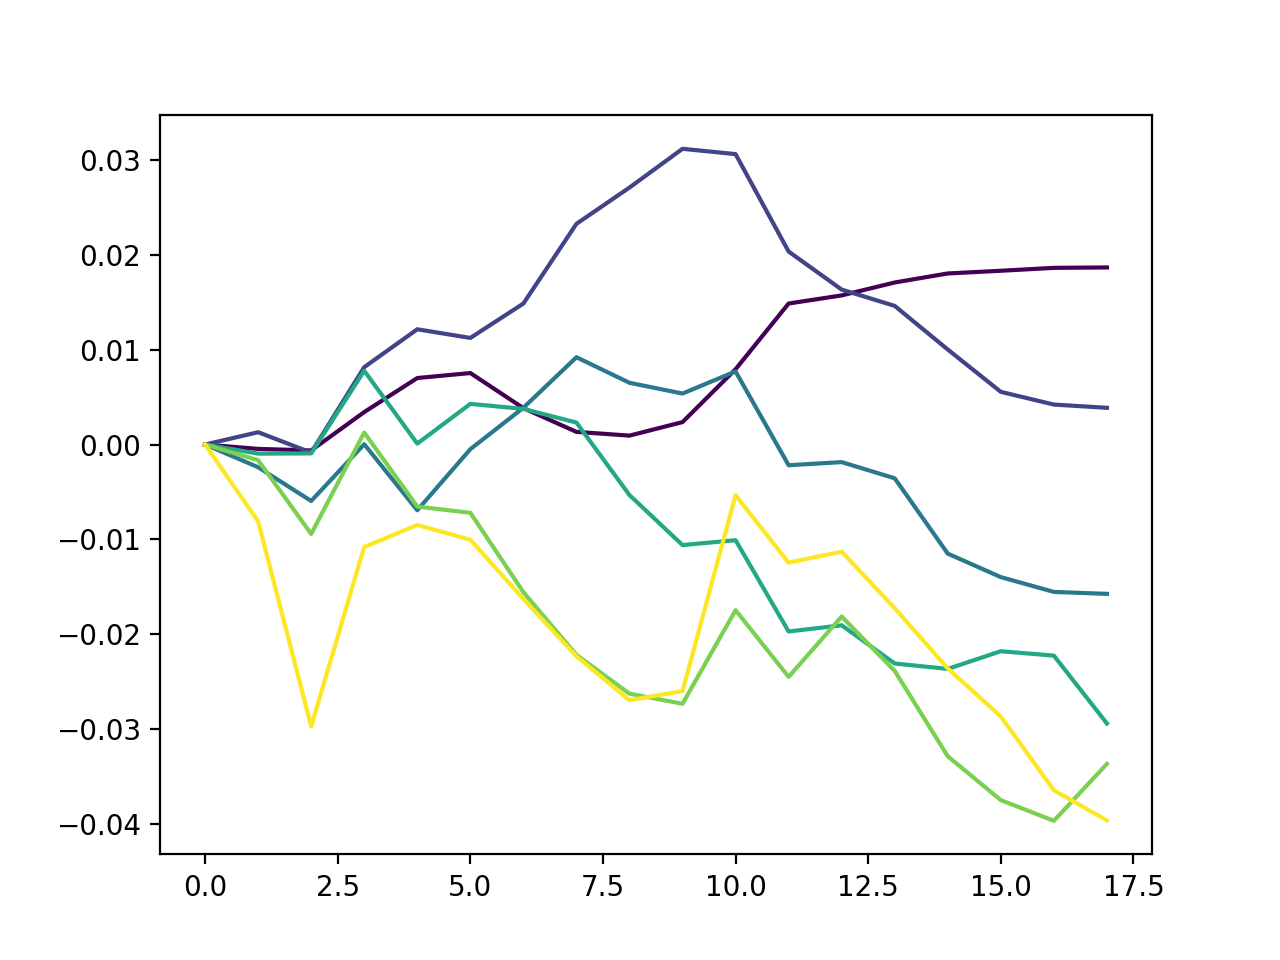

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


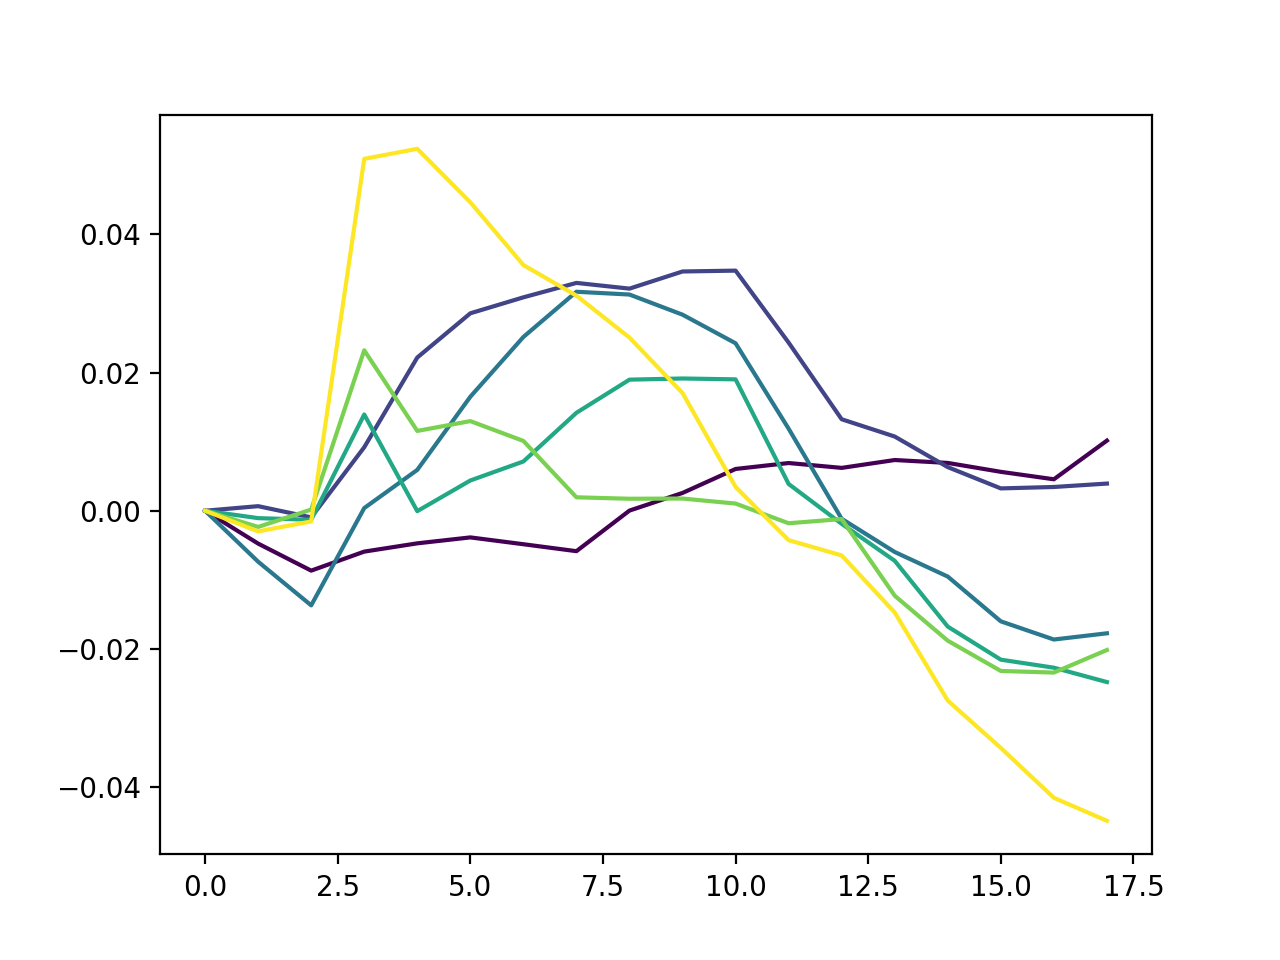

<IPython.core.display.Javascript object>


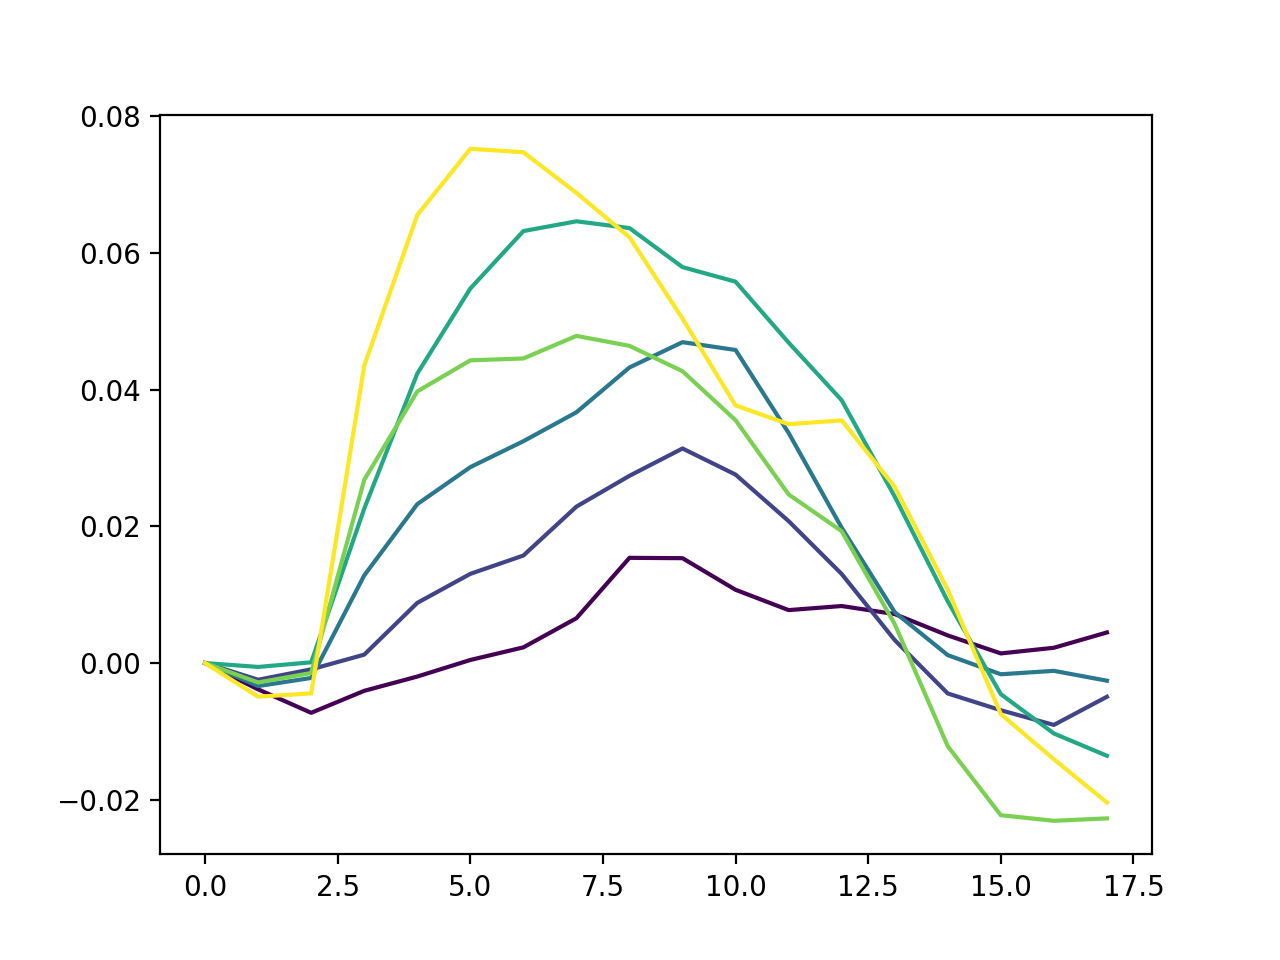

In [35]:
for iexpt in range(len(tunings_sc[0][1])):
    isize = 4
    if not tunings_sc[0][1][iexpt] is None:
        this_data = tunings_sc[0][1][iexpt][:,:,:,:,6:]
        colors = plt.cm.viridis(np.linspace(0,1,this_data.shape[2]))
        plt.figure()
        for icontrast in range(colors.shape[0]):
            to_plot = np.nanmean(np.nanmean(this_data,3),0)[isize,icontrast,:]
            plt.plot(to_plot-to_plot[0],c=colors[icontrast])


In [28]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.267968, 0.223549, 0.512008, 1.      ],
       [0.190631, 0.407061, 0.556089, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.20803 , 0.718701, 0.472873, 1.      ],
       [0.565498, 0.84243 , 0.262877, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

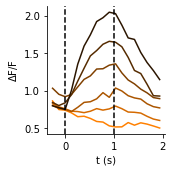

In [43]:
# c_sst_full = np.array([np.array((1,0.65,0))*icontrast/5 for icontrast in range(6)])
iexpt = 8
for iroi in [3]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_sc_sst_vip[0][0][iexpt][iroi,:,:,:,6:]
    t = (np.arange(data.shape[-1])-2)/7.75
    mn = np.nanmean(data)
    contrast_colors = plt.cm.viridis(np.linspace(0,1,6))
    data = data/mn
#     isize = 3
    for icontrast in np.arange(6):
        plt.plot(t,np.nanmean(np.nanmean(data,2),0)[icontrast],c=c_sst_full[icontrast])
#     plt.xticks([0,4,8],[-20,0,20])
#     plt.yticks([0,4,8],[20,0,-20])
#     plt.ylim(8.5,-0.5)
#     plt.xlabel('azimuth ($^o$)')
#     plt.ylabel('elevation ($^o$)')
    plt.xlabel('t (s)')
    plt.ylabel(r'$\Delta$F/F')
    plt.tight_layout()
    ut.erase_top_right()
    plt.axvline(0,c='k',linestyle='dashed')
    plt.axvline(1,c='k',linestyle='dashed')
    plt.savefig('figures/example_sst_neuron_contrast_timecourse_expt_%d_roi_%d.eps'%(iexpt,iroi))

<IPython.core.display.Javascript object>


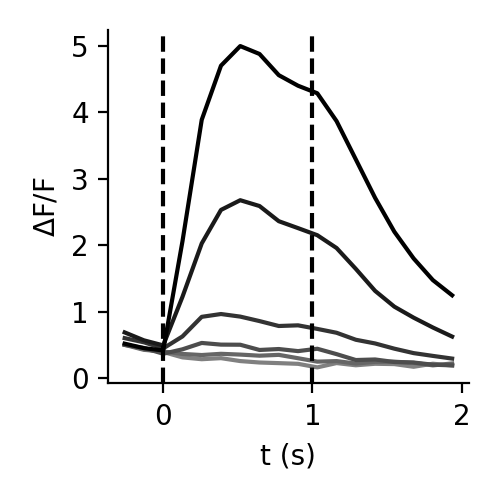

<IPython.core.display.Javascript object>


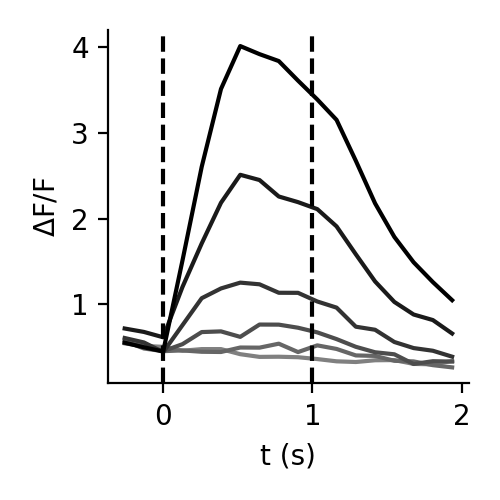

<IPython.core.display.Javascript object>


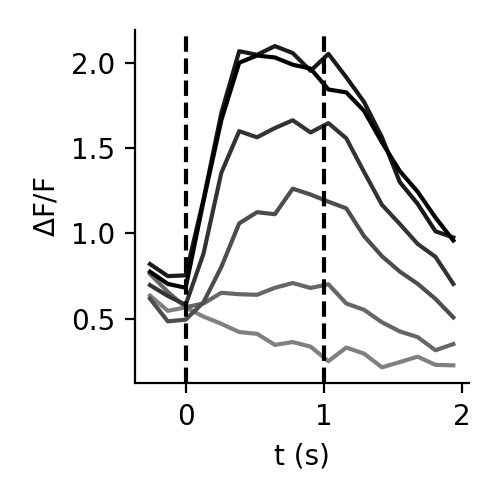

<IPython.core.display.Javascript object>


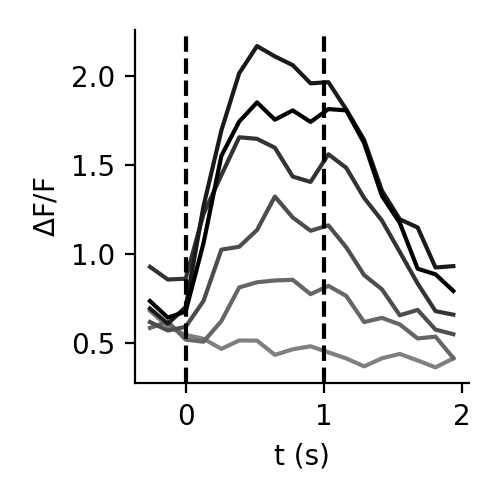

In [232]:
c_l23_full = np.array([np.array((0.5,0.5,0.5))*(5-icontrast)/5 for icontrast in range(6)])
iexpt = 12
for iroi in [15,18,47,74]:
    plt.figure(figsize=(2.5,2.5))
    data = tunings_sc[0][0][iexpt][iroi,:,:,:,6:]
    t = (np.arange(data.shape[-1])-2)/7.75
    mn = np.nanmean(data)
    contrast_colors = plt.cm.viridis(np.linspace(0,1,6))
    data = data/mn
#     isize = 3
    for icontrast in np.arange(6):
        plt.plot(t,np.nanmean(np.nanmean(data,2),0)[icontrast],c=c_l23_full[icontrast])
#     plt.xticks([0,4,8],[-20,0,20])
#     plt.yticks([0,4,8],[20,0,-20])
#     plt.ylim(8.5,-0.5)
#     plt.xlabel('azimuth ($^o$)')
#     plt.ylabel('elevation ($^o$)')
    plt.xlabel('t (s)')
    plt.ylabel(r'$\Delta$F/F')
    plt.tight_layout()
    ut.erase_top_right()
    plt.axvline(0,c='k',linestyle='dashed')
    plt.axvline(1,c='k',linestyle='dashed')
    plt.savefig('figures/example_pc_neuron_contrast_timecourse_expt_%d_roi_%d.eps'%(iexpt,iroi))

In [437]:
ret_info[0][0][12]['amplitude'].max()

6744.165399658142

In [482]:
def nansem(data):
    return np.nanstd(data)/np.sqrt(np.sum(~np.isnan(data)))
def n_non_nan(data):
    return np.sum(~np.isnan(data))

In [507]:
np.nanmean(np.nanmean(tunings_decon[0][0][iexpt][:,:,[0,-5,-4,-3,-2,-1],:,8:-8],4),3).shape

(2270, 6, 6)

In [ ]:
print('ok')

In [ ]:
nsize,ncontrast = 6,6
irun,itype,ialign = 0,0,0
nexpt = len(ret_info[0][0])
bins = np.linspace(0,30,16)
nbin = len(bins)-1
data_bin = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
data_sem = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
osi_bin = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
osi_sem = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
data_n = np.nan*np.ones((nexpt,nbin,nsize,ncontrast))
for iexpt in range(nexpt):
    if not ret_info[0][0][iexpt]['ret_map_loc'] is None and not tunings_decon[0][0][iexpt] is None:
#         distance = np.sqrt(np.sum(ret_info[0][0][iexpt]['ret_map_loc']**2,1))
        distance = np.sqrt(np.sum(ret_info[0][0][iexpt]['rf_center']**2,1))
        data = np.nanmean(np.nanmean(tunings_decon[0][0][iexpt][:,:,[0,-5,-4,-3,-2,-1],:,8:-8],4),3)
        osi_data = ut.compute_osi(np.nanmean(tunings_decon[0][0][iexpt][:,:,[0,-5,-4,-3,-2,-1],:,8:-8],4)[:,:,:,:,np.newaxis],np.arange(0,360,45))
#         data = np.nanmean(rs[irun][itype][ialign][(expt_ids[irun][itype][ialign]==iexpt)],3)
        data = data/np.nanmean(data)
#         data = data/np.nanmean(np.nanmean(data,1),1)[:,np.newaxis,np.newaxis]
        non_nan = ~np.isnan(np.nanmean(np.nanmean(data,1),1))
        sig_driven = (ret_info[0][0][iexpt]['pval'] < 0.05) & (ret_info[0][0][iexpt]['amplitude'] > 0) & (ret_info[0][0][iexpt]['sigma'] > 3.3)
        lkat = non_nan & sig_driven
        this_nsize = data.shape[1]
        if np.sum(lkat):
            for isize in range(this_nsize):
                for icontrast in range(ncontrast):
                    data_bin[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=np.nanmean,bins=bins).statistic
                    data_sem[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=nansem,bins=bins).statistic
                    osi_bin[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=np.nanmean,bins=bins).statistic
                    osi_sem[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=nansem,bins=bins).statistic
                    data_n[iexpt,:,isize,icontrast] = sst.binned_statistic(distance[lkat],data[lkat,isize,icontrast],statistic=n_non_nan,bins=bins).statistic
data_bin[data_n < 10] = np.nan
data_sem[data_n < 10] = np.nan
osi_bin[data_n < 10] = np.nan
osi_sem[data_n < 10] = np.nan
data_bin[:,:,:,:] = data_bin[:,:,:,:]-data_bin[:,:,:,0:1]
# data_sem[:,:,:,:] = data_sem[:,:,:,:]/np.nanmean(np.nanmean(np.nanmean(data_bin[:,:,:,:],2),2),0)[np.newaxis,:,np.newaxis,np.newaxis]
# data_bin[:,:,:,:] = data_bin[:,:,:,:]/np.nanmean(np.nanmean(np.nanmean(data_bin[:,:,:,:],2),2),0)[np.newaxis,:,np.newaxis,np.newaxis]

In [ ]:
plt.figure()
for ibin in range(nbin):
    plt.subplot(3,5,ibin+1)
    plt.imshow(np.nanmean(data_bin,0)[ibin])

In [503]:
usize = np.array((5,8,13,22,36,60))

In [504]:
data_n[:,0,0,0]

array([nan,  5., nan,  1.,  0.,  2., nan, 25., 27., nan,  4.,  3., 17.])

<IPython.core.display.Javascript object>


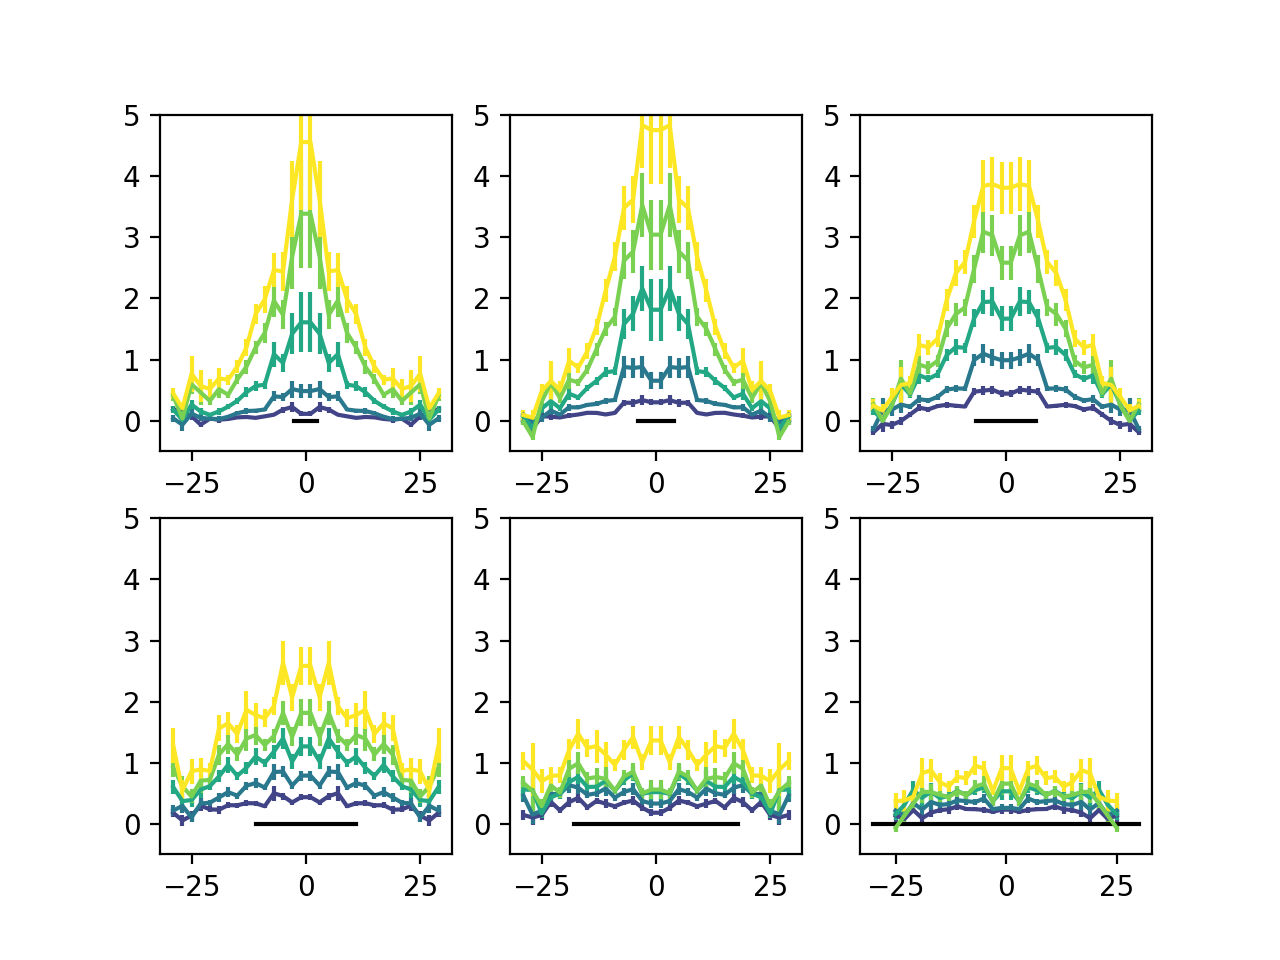

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [505]:
colors = plt.cm.viridis(np.linspace(0,1,6))
x = 0.5*(bins[1:]+bins[:-1])
x = np.concatenate((-x[::-1],x))
plt.figure()
for isize in range(nsize):
    plt.subplot(2,3,isize+1)
    for icontrast in range(1,ncontrast):
        lkat = data_n[:,:,isize,icontrast]
        data = np.nanmean(data_bin[:,:,isize,icontrast],0)
        data = np.concatenate((data[::-1],data))
        this_sem = np.sqrt(np.nansum(data_sem[:,:,isize,icontrast]**2,0))/np.sum(~np.isnan(data_sem[:,:,isize,icontrast]),0)
        this_sem = np.concatenate((this_sem[::-1],this_sem))
        plt.errorbar(x,data,this_sem,c=colors[icontrast])
    plt.ylim((-0.5,5))
    plt.plot((-usize[isize]/2,usize[isize]/2),(0,0),c='k')

In [453]:
np.nanmean(data_bin[:,:,isize,icontrast],0).shape

(10,)